In [1]:
import os
import sys
import time
import math
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from pathlib import Path as Path
from urllib import request
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import gc
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import plotly.express as px
from impyute.imputation.cs import fast_knn

from operator import attrgetter

color = sns.color_palette('colorblind')
# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

c:\Users\harsh\Desktop\portfolio\envs\leadschool1\lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


# Initializing

## Loading data

Creating subfolder for data

In [2]:
#creating a new directory called pythondirectory
Path("data").mkdir(parents=True, exist_ok=True)

Fetching csv from GitHub repo

In [3]:
start = time.perf_counter()
closeddealsdata = request.urlretrieve("https://raw.githubusercontent.com/harsh21051993/rough_portfolio/main/marketing/mql1/data/olist_closed_deals_dataset.csv", "./data/closed_deals.csv")
end = time.perf_counter()
print(f'Fetch time = {math.floor((end-start)*1000)} milliseconds')

Fetch time = 1076 milliseconds


In [4]:
start = time.perf_counter()
mqldata = request.urlretrieve("https://raw.githubusercontent.com/harsh21051993/rough_portfolio/main/marketing/mql1/data/olist_marketing_qualified_leads_dataset.csv", "./data/marketing_qualified_leads.csv")
end = time.perf_counter()
print(f'Fetch time = {math.floor((end-start)*1000)} milliseconds')

Fetch time = 736 milliseconds


Loading csv into dataframe

In [5]:
start = time.perf_counter()
closed_deals = pd.read_csv('./data/closed_deals.csv')
closed_deals.info()
end = time.perf_counter()
print(f'Load time = {math.floor((end-start)*1000)} milliseconds')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         842 non-null    object 
 1   seller_id                      842 non-null    object 
 2   sdr_id                         842 non-null    object 
 3   sr_id                          842 non-null    object 
 4   won_date                       842 non-null    object 
 5   business_segment               841 non-null    object 
 6   lead_type                      836 non-null    object 
 7   lead_behaviour_profile         665 non-null    object 
 8   has_company                    63 non-null     object 
 9   has_gtin                       64 non-null     object 
 10  average_stock                  66 non-null     object 
 11  business_type                  832 non-null    object 
 12  declared_product_catalog_size  69 non-null     flo

In [6]:
start = time.perf_counter()
mql_df = pd.read_csv('./data/marketing_qualified_leads.csv')
mql_df.info()
end = time.perf_counter()
print(f'Load time = {math.floor((end-start)*1000)} milliseconds')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mql_id              8000 non-null   object
 1   first_contact_date  8000 non-null   object
 2   landing_page_id     8000 non-null   object
 3   origin              7940 non-null   object
dtypes: object(4)
memory usage: 250.1+ KB
Load time = 12 milliseconds


## Changing data

Changing type of date column

In [7]:
mql_df.first_contact_date = pd.to_datetime(mql_df.first_contact_date)

In [8]:
mql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   mql_id              8000 non-null   object        
 1   first_contact_date  8000 non-null   datetime64[ns]
 2   landing_page_id     8000 non-null   object        
 3   origin              7940 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 250.1+ KB


In [9]:
mql_df['first_contact_year'] = mql_df.first_contact_date.dt.year
mql_df['first_contact_month'] = mql_df.first_contact_date.dt.month
mql_df['first_contact_day'] = mql_df.first_contact_date.dt.day
mql_df['first_contact_day_week'] = mql_df.first_contact_date.dt.dayofweek

In [10]:
mql_df.head()

,mql_id,first_contact_date,landing_page_id,origin,first_contact_year,first_contact_month,first_contact_day,first_contact_day_week
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,2018,2,1,3
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,2017,10,20,4
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,2018,3,22,3
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,2018,1,22,0
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2018,2,21,2


In [11]:
mql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   mql_id                  8000 non-null   object        
 1   first_contact_date      8000 non-null   datetime64[ns]
 2   landing_page_id         8000 non-null   object        
 3   origin                  7940 non-null   object        
 4   first_contact_year      8000 non-null   int64         
 5   first_contact_month     8000 non-null   int64         
 6   first_contact_day       8000 non-null   int64         
 7   first_contact_day_week  8000 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 500.1+ KB


In [12]:
closed_deals.won_date = pd.to_datetime(closed_deals.won_date)

In [13]:
closed_deals['won_year'] = closed_deals.won_date.dt.year
closed_deals['won_month'] = closed_deals.won_date.dt.month + 1
closed_deals['won_day'] = closed_deals.won_date.dt.day
closed_deals['won_day_week'] = closed_deals.won_date.dt.dayofweek

In [14]:
closed_deals.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,won_year,won_month,won_day,won_day_week
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018,3,26,0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018,6,8,1
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018,7,5,1
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018,2,17,2
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2018,8,3,1


In [15]:
closed_deals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         842 non-null    object        
 1   seller_id                      842 non-null    object        
 2   sdr_id                         842 non-null    object        
 3   sr_id                          842 non-null    object        
 4   won_date                       842 non-null    datetime64[ns]
 5   business_segment               841 non-null    object        
 6   lead_type                      836 non-null    object        
 7   lead_behaviour_profile         665 non-null    object        
 8   has_company                    63 non-null     object        
 9   has_gtin                       64 non-null     object        
 10  average_stock                  66 non-null     object        
 11  business_type      

Adding new column *'closed'* to *closed_deals* with all 1

In [16]:
closed_deals['closed'] = 1

Creating 2 new functions for displaying null values and changing types of numeric columns

In [2]:
def display_null(input_df, name):
  df1 = pd.DataFrame(input_df.dtypes).T.rename(index={0:'column dtype'})
  df2 = pd.DataFrame(input_df.isnull().sum()).T.rename(index={0:'count null values'})
  df3 = pd.DataFrame(input_df.isnull().sum()/input_df.shape[0]*100).T.rename(index={0:'% null values'})
  infodf = pd.concat([df1,df2,df3])
  print(f'Dataframe name = {name}')
  print
  display(infodf)
  print('\n')

In [3]:
def reduce_memory(df):
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    start_mem_usg = math.floor(df.memory_usage().sum() / 1024**2) 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print(f"Memory reduction = {math.floor((mem_usg/start_mem_usg)*100)}%")
    return df

Creating a new dataframe for analyzing only closed deals

In [19]:
closed_merged = pd.merge(closed_deals, mql_df, on='mql_id', how='left')
closed_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 841
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         842 non-null    object        
 1   seller_id                      842 non-null    object        
 2   sdr_id                         842 non-null    object        
 3   sr_id                          842 non-null    object        
 4   won_date                       842 non-null    datetime64[ns]
 5   business_segment               841 non-null    object        
 6   lead_type                      836 non-null    object        
 7   lead_behaviour_profile         665 non-null    object        
 8   has_company                    63 non-null     object        
 9   has_gtin                       64 non-null     object        
 10  average_stock                  66 non-null     object        
 11  business_type      

In [20]:
delta = closed_merged['won_date'] - closed_merged['first_contact_date']
closed_merged['won_duration_days'] = delta.dt.days.astype(float) + (delta.dt.seconds.astype(float) / 86400)
closed_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 841
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         842 non-null    object        
 1   seller_id                      842 non-null    object        
 2   sdr_id                         842 non-null    object        
 3   sr_id                          842 non-null    object        
 4   won_date                       842 non-null    datetime64[ns]
 5   business_segment               841 non-null    object        
 6   lead_type                      836 non-null    object        
 7   lead_behaviour_profile         665 non-null    object        
 8   has_company                    63 non-null     object        
 9   has_gtin                       64 non-null     object        
 10  average_stock                  66 non-null     object        
 11  business_type      

In [21]:
closed_merged['won_duration_months'] = (closed_merged.won_date.dt.to_period('M') - closed_merged.first_contact_date.dt.to_period('M')).apply(attrgetter('n'))
closed_merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 841
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         842 non-null    object        
 1   seller_id                      842 non-null    object        
 2   sdr_id                         842 non-null    object        
 3   sr_id                          842 non-null    object        
 4   won_date                       842 non-null    datetime64[ns]
 5   business_segment               841 non-null    object        
 6   lead_type                      836 non-null    object        
 7   lead_behaviour_profile         665 non-null    object        
 8   has_company                    63 non-null     object        
 9   has_gtin                       64 non-null     object        
 10  average_stock                  66 non-null     object        
 11  business_type      

In [22]:
closed_merged.head(10)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,won_year,won_month,won_day,won_day_week,closed,first_contact_date,landing_page_id,origin,first_contact_year,first_contact_month,first_contact_day,first_contact_day_week,won_duration_days,won_duration_months
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018,3,26,0,1,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2018,2,21,2,5.832569,0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018,6,8,1,1,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,2018,4,4,2,34.845822,1
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018,7,5,1,1,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,2018,4,3,1,63.727350,2
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018,2,17,2,1,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,2018,1,14,6,3.577118,0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2018,8,3,1,1,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,2017,10,9,0,267.845660,9
5,b94fba7670eeb44dce2a0d8eb790e9f5,1c742ac33582852aaf3bcfbf5893abcf,fdb16d3cbbeb5798f2f66c4096be026d,495d4e95a8cf8bbf8b432b612a2aa328,2018-02-07 18:04:05,health_beauty,online_medium,NaN,NaN,NaN,NaN,manufacturer,NaN,0.0,2018,3,7,2,1,2018-02-06,40dec9f3d5259a3d2dbcdab2114fae47,organic_search,2018,2,6,1,1.752836,0
6,c3e30ed7ac989117c7e1e719b4ac128f,92d7568ad0c5c76fd7d341b2d46f24d6,4b339f9567d060bcea4f5136b9f5949e,85fc447d336637ba1df43e793199fbc8,2018-04-16 18:18:22,computers,online_medium,wolf,NaN,NaN,NaN,reseller,NaN,0.0,2018,5,16,0,1,2018-02-20,e492ee5eaf1697716985cc6f33f9cd9b,direct_traffic,2018,2,20,1,55.762755,2
7,b02c89251106e1fdd9d92744be9f94f2,44ed138eca6214d572ce1d813fb0049b,34d40cdaf94010a1d05b0d6212f9e909,4ef15afb4b2723d8f3d81e51ec7afefe,2018-04-17 17:01:57,health_beauty,offline,cat,NaN,NaN,NaN,manufacturer,NaN,0.0,2018,5,17,1,1,2018-04-13,b76ef37428e6799c421989521c0e5077,unknown,2018,4,13,4,4.709688,0
8,a90a37898cc5f2718385a2fb981caaff,0b28859cd04d23edefee9c591fb03cd8,f42a2bd194f7802ab052a815c8de65b7,6565aa9ce3178a5caf6171827af3a9ba,2018-05-14 18:37:15,household_utilities,offline,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018,6,14,0,1,2018-04-27,58326e62183c14b0c03085c33b9fdc44,social,2018,4,27,4,17.775868,1
9,0173e8d8b1d94a355b440fb67388f532,87d73636a3acf123e842bb890a4db036,9d12ef1a7eca3ec58c545c678af7869c,9e4d1098a3b0f5da39b0bc48f9876645,2018-04-24 03:00:00,household_utilities,online_medium,eagle,NaN,NaN,NaN,manufacturer,NaN,0.0,2018,5,24,1,1,2017-10-18,007f9098284a86ee80ddeb25d53e0af8,paid_search,2017,10,18,2,188.125000,6


Create dataframe for analyzing all deals

In [23]:
alldeals = pd.merge(mql_df, closed_merged, on='mql_id', how='outer')
alldeals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date_x           8000 non-null   datetime64[ns]
 2   landing_page_id_x              8000 non-null   object        
 3   origin_x                       7940 non-null   object        
 4   first_contact_year_x           8000 non-null   int64         
 5   first_contact_month_x          8000 non-null   int64         
 6   first_contact_day_x            8000 non-null   int64         
 7   first_contact_day_week_x       8000 non-null   int64         
 8   seller_id                      842 non-null    object        
 9   sdr_id                         842 non-null    object        
 10  sr_id                          842 non-null    object        
 11  won_date         

In [24]:
alldeals = alldeals.drop(['first_contact_date_y', 'first_contact_year_y', 'first_contact_month_y', 'first_contact_day_y',
                        'first_contact_day_week_y', 'landing_page_id_y', 'origin_y'], axis=1)
alldeals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date_x           8000 non-null   datetime64[ns]
 2   landing_page_id_x              8000 non-null   object        
 3   origin_x                       7940 non-null   object        
 4   first_contact_year_x           8000 non-null   int64         
 5   first_contact_month_x          8000 non-null   int64         
 6   first_contact_day_x            8000 non-null   int64         
 7   first_contact_day_week_x       8000 non-null   int64         
 8   seller_id                      842 non-null    object        
 9   sdr_id                         842 non-null    object        
 10  sr_id                          842 non-null    object        
 11  won_date         

In [25]:
alldeals.rename(columns={'first_contact_date_x':'first_contact_date', 'landing_page_id_x':'landing_page_id', 'origin_x':'origin',
'first_contact_year_x':'first_contact_year', 'first_contact_month_x':'first_contact_month',
'first_contact_day_x':'first_contact_day', 'first_contact_day_week_x':'first_contact_day_week'}, inplace=True)
alldeals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date             8000 non-null   datetime64[ns]
 2   landing_page_id                8000 non-null   object        
 3   origin                         7940 non-null   object        
 4   first_contact_year             8000 non-null   int64         
 5   first_contact_month            8000 non-null   int64         
 6   first_contact_day              8000 non-null   int64         
 7   first_contact_day_week         8000 non-null   int64         
 8   seller_id                      842 non-null    object        
 9   sdr_id                         842 non-null    object        
 10  sr_id                          842 non-null    object        
 11  won_date         

Saving these 4 datarames as backup
>Feather is a binary data format.

>Feather enables faster I/O speeds and less memory. However, since it is an evolving format, it is recommended to use it for quick loading and transformation related data processing.

In [26]:
closed_deals.to_feather('./data/closed_deals.feather')
mql_df.to_feather('./data/mql_df.feather')
closed_merged.to_feather('./data/closed_merged.feather')
alldeals.to_feather('./data/alldeals.feather')

# EDA

Reading dataframes

In [27]:
mql_df = pd.read_feather('./data/mql_df.feather')
closed_deals = pd.read_feather('./data/closed_deals.feather')
closed_merged = pd.read_feather('./data/closed_merged.feather')
alldeals = pd.read_feather('./data/alldeals.feather')

In [28]:
alldeals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date             8000 non-null   datetime64[ns]
 2   landing_page_id                8000 non-null   object        
 3   origin                         7940 non-null   object        
 4   first_contact_year             8000 non-null   int64         
 5   first_contact_month            8000 non-null   int64         
 6   first_contact_day              8000 non-null   int64         
 7   first_contact_day_week         8000 non-null   int64         
 8   seller_id                      842 non-null    object        
 9   sdr_id                         842 non-null    object        
 10  sr_id                          842 non-null    object        
 11  won_date         

## Analyzing leads by origin

In [31]:
print(f'Number of unique sources of leads = {alldeals.origin.nunique()}')

Number of unique sources of leads = 10


In [32]:
print(f'Total number of unique MQL = {alldeals.mql_id.nunique()}')

Total number of unique MQL = 8000


In [33]:
origindf = alldeals.groupby('origin').agg(
    closed_deals_mql=('closed','sum'),
    total_mql_by_origin=('mql_id','count'),
    avg_months_to_close=('won_duration_months', 'mean'),
    avg_days_to_close=('won_duration_days', 'mean'),
    avg_monthly_revenue=('declared_monthly_revenue','mean'),
    count_business_segment=('business_segment','nunique'),
    count_business_type=('business_type','nunique'),
    count_lead_type=('lead_type','count'),
    count_lead_behaviour=('lead_behaviour_profile','nunique'),
)
origindf = origindf.sort_values('closed_deals_mql', ascending=False).reset_index()
origindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   origin                  10 non-null     object 
 1   closed_deals_mql        10 non-null     float64
 2   total_mql_by_origin     10 non-null     int64  
 3   avg_months_to_close     10 non-null     float64
 4   avg_days_to_close       10 non-null     float64
 5   avg_monthly_revenue     10 non-null     float64
 6   count_business_segment  10 non-null     int64  
 7   count_business_type     10 non-null     int64  
 8   count_lead_type         10 non-null     int64  
 9   count_lead_behaviour    10 non-null     int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 928.0+ bytes


In [34]:
origindf.head(10)

,origin,closed_deals_mql,total_mql_by_origin,avg_months_to_close,avg_days_to_close,avg_monthly_revenue,count_business_segment,count_business_type,count_lead_type,count_lead_behaviour
0,organic_search,271.0,2296,1.616236,50.661058,189763.837638,31,3,268,9
1,paid_search,195.0,1586,1.835897,57.274347,47020.512821,29,3,195,6
2,unknown,179.0,1099,1.296089,41.942943,2586.625698,30,2,177,6
3,social,75.0,1350,1.920000,61.619110,6680.000000,20,2,75,4
4,direct_traffic,56.0,499,0.982143,31.767716,1071.428571,21,2,55,4
5,referral,24.0,284,1.041667,33.242988,0.000000,14,2,24,3
6,email,15.0,493,1.733333,52.773204,1000.000000,12,2,15,3
7,display,6.0,118,0.000000,10.921914,0.000000,5,2,6,3
8,other,4.0,150,0.250000,15.766713,0.000000,4,1,4,2
9,other_publicities,3.0,65,1.333333,40.075467,0.000000,2,2,3,1


<AxesSubplot: xlabel='origin'>

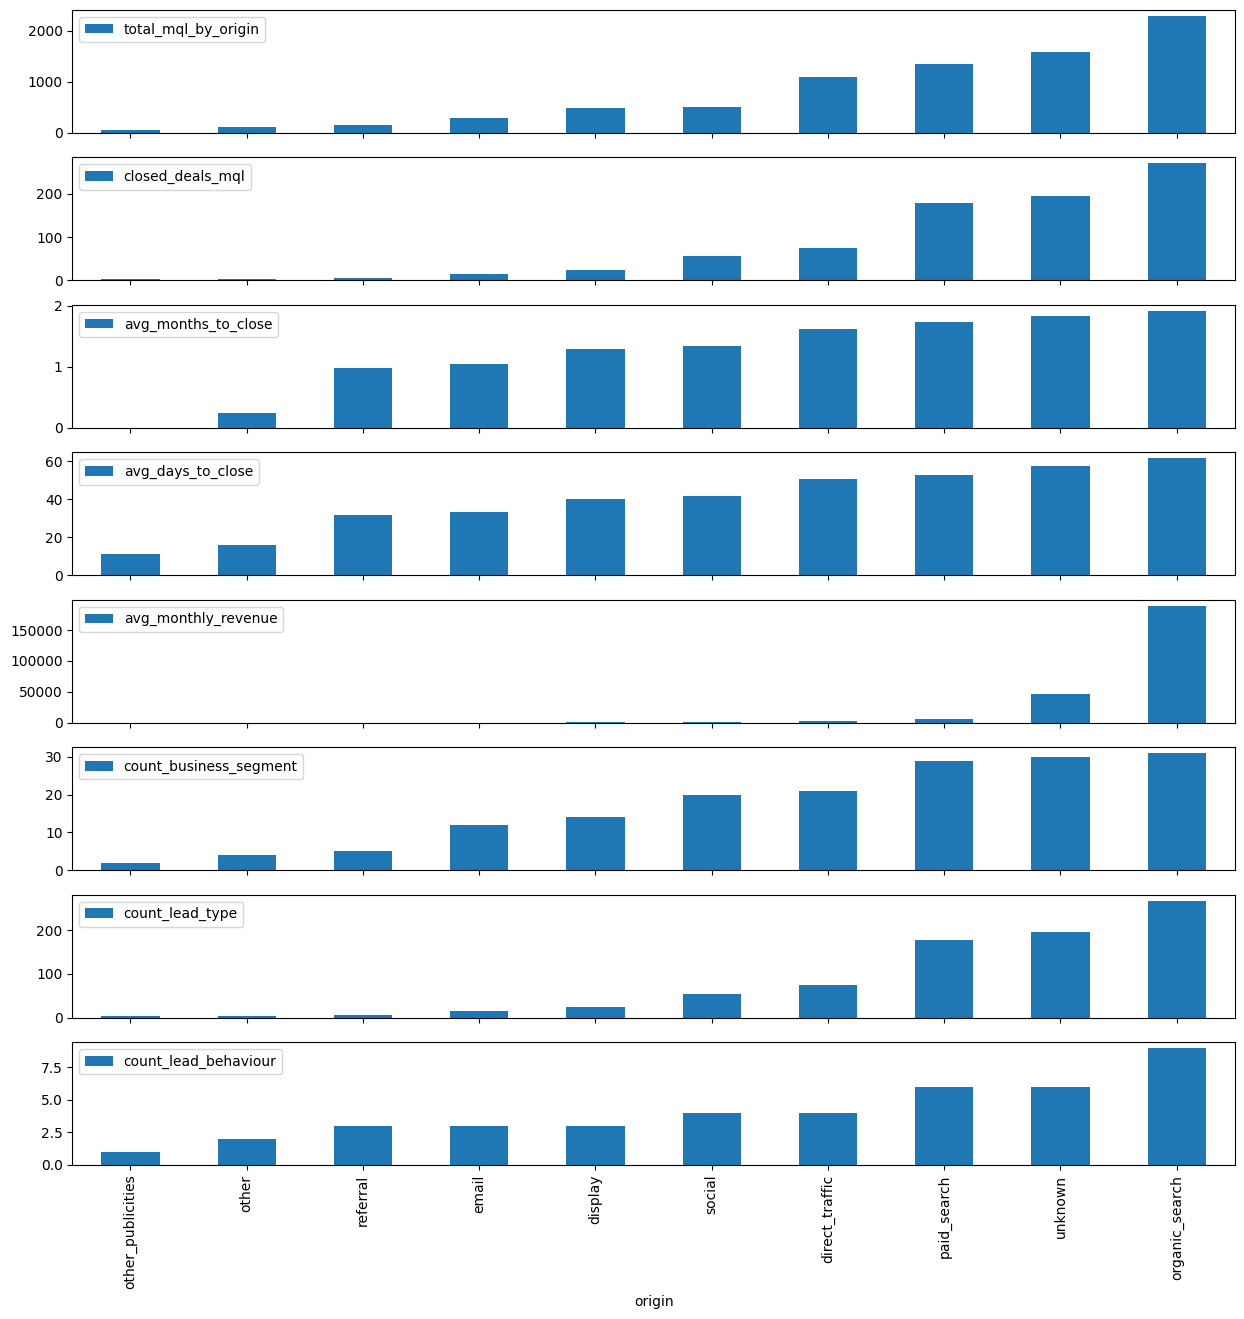

In [35]:
fig, axes = plt.subplots(nrows=8, ncols=1, sharex=True, figsize=(15,15))
origindf.sort_values(by='total_mql_by_origin').plot(x='origin', y='total_mql_by_origin', kind='bar', ax=axes[0])
origindf.sort_values(by='closed_deals_mql').plot(x='origin', y='closed_deals_mql', kind='bar', ax=axes[1])
origindf.sort_values(by='avg_months_to_close').plot(x='origin', y='avg_months_to_close', kind='bar', ax=axes[2])
origindf.sort_values(by='avg_days_to_close').plot(x='origin', y='avg_days_to_close', kind='bar', ax=axes[3])
origindf.sort_values(by='avg_monthly_revenue').plot(x='origin', y='avg_monthly_revenue', kind='bar', ax=axes[4])
origindf.sort_values(by='count_business_segment').plot(x='origin', y='count_business_segment', kind='bar', ax=axes[5])
origindf.sort_values(by='count_lead_type').plot(x='origin', y='count_lead_type', kind='bar', ax=axes[6])
origindf.sort_values(by='count_lead_behaviour').plot(x='origin', y='count_lead_behaviour', kind='bar', ax=axes[7])

## Analyzing leads w.r.t business_segment

In [43]:
print(f'Number of business segments = {alldeals.business_segment.nunique()}')

Number of business segments = 33


Plotting count of unique business_segment

<AxesSubplot: title={'center': 'Different business segments'}, xlabel='Count', ylabel='business_segment'>

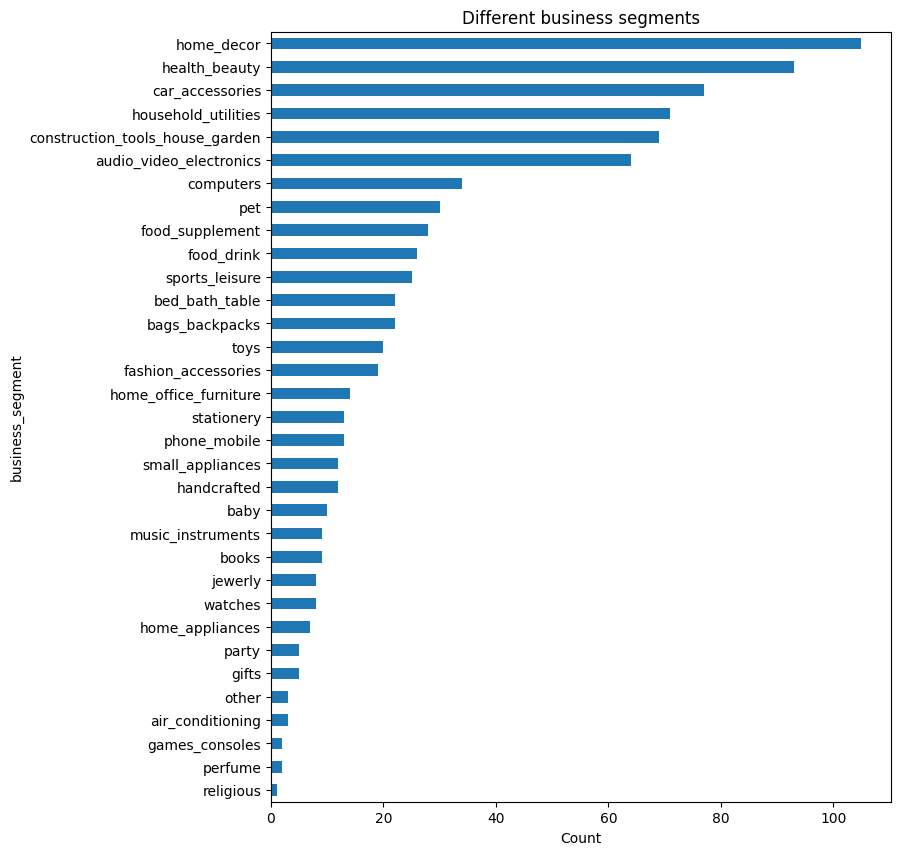

In [42]:
alldeals['business_segment'].value_counts().sort_values().plot(xlabel='Count',ylabel='business_segment', kind='barh', figsize=(8,10), title='Different business segments')


In [47]:
segmentdf = alldeals.groupby('business_segment').agg(
    closed_deals_mql=('closed','sum'),
    total_mql_by_segment=('mql_id','count'),
    avg_months_to_close=('won_duration_months', 'mean'),
    avg_days_to_close=('won_duration_days', 'mean'),
    avg_monthly_revenue=('declared_monthly_revenue','mean'),
    count_origin=('origin','nunique'),
    count_business_type=('business_type','nunique'),
    count_lead_type=('lead_type','count'),
    count_lead_behaviour=('lead_behaviour_profile','nunique'),
)
segmentdf = segmentdf.sort_values('closed_deals_mql', ascending=False).reset_index()
segmentdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   business_segment      33 non-null     object 
 1   closed_deals_mql      33 non-null     float64
 2   total_mql_by_segment  33 non-null     int64  
 3   avg_months_to_close   33 non-null     float64
 4   avg_days_to_close     33 non-null     float64
 5   avg_monthly_revenue   33 non-null     float64
 6   count_origin          33 non-null     int64  
 7   count_business_type   33 non-null     int64  
 8   count_lead_type       33 non-null     int64  
 9   count_lead_behaviour  33 non-null     int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 2.7+ KB


In [48]:
segmentdf.head(10)

,business_segment,closed_deals_mql,total_mql_by_segment,avg_months_to_close,avg_days_to_close,avg_monthly_revenue,count_origin,count_business_type,count_lead_type,count_lead_behaviour
0,home_decor,105.0,105,1.619048,50.724674,6761.904762,9,2,104,4
1,health_beauty,93.0,93,1.129032,35.704757,3172.043011,9,2,93,5
2,car_accessories,77.0,77,1.636364,51.099037,2402.597403,8,2,77,5
3,household_utilities,71.0,71,1.661972,53.483502,2295.774648,7,2,70,5
4,construction_tools_house_garden,69.0,69,1.913043,61.354986,734710.231884,8,2,69,4
5,audio_video_electronics,64.0,64,1.906250,63.906866,4218.750000,7,2,63,4
6,computers,34.0,34,1.764706,55.676528,3088.235294,7,1,33,5
7,pet,30.0,30,1.000000,29.855551,10000.000000,6,2,29,4
8,food_supplement,28.0,28,1.285714,39.029809,0.000000,7,2,28,3
9,food_drink,26.0,26,1.000000,32.236474,384.615385,6,2,26,4


<AxesSubplot: xlabel='business_segment'>

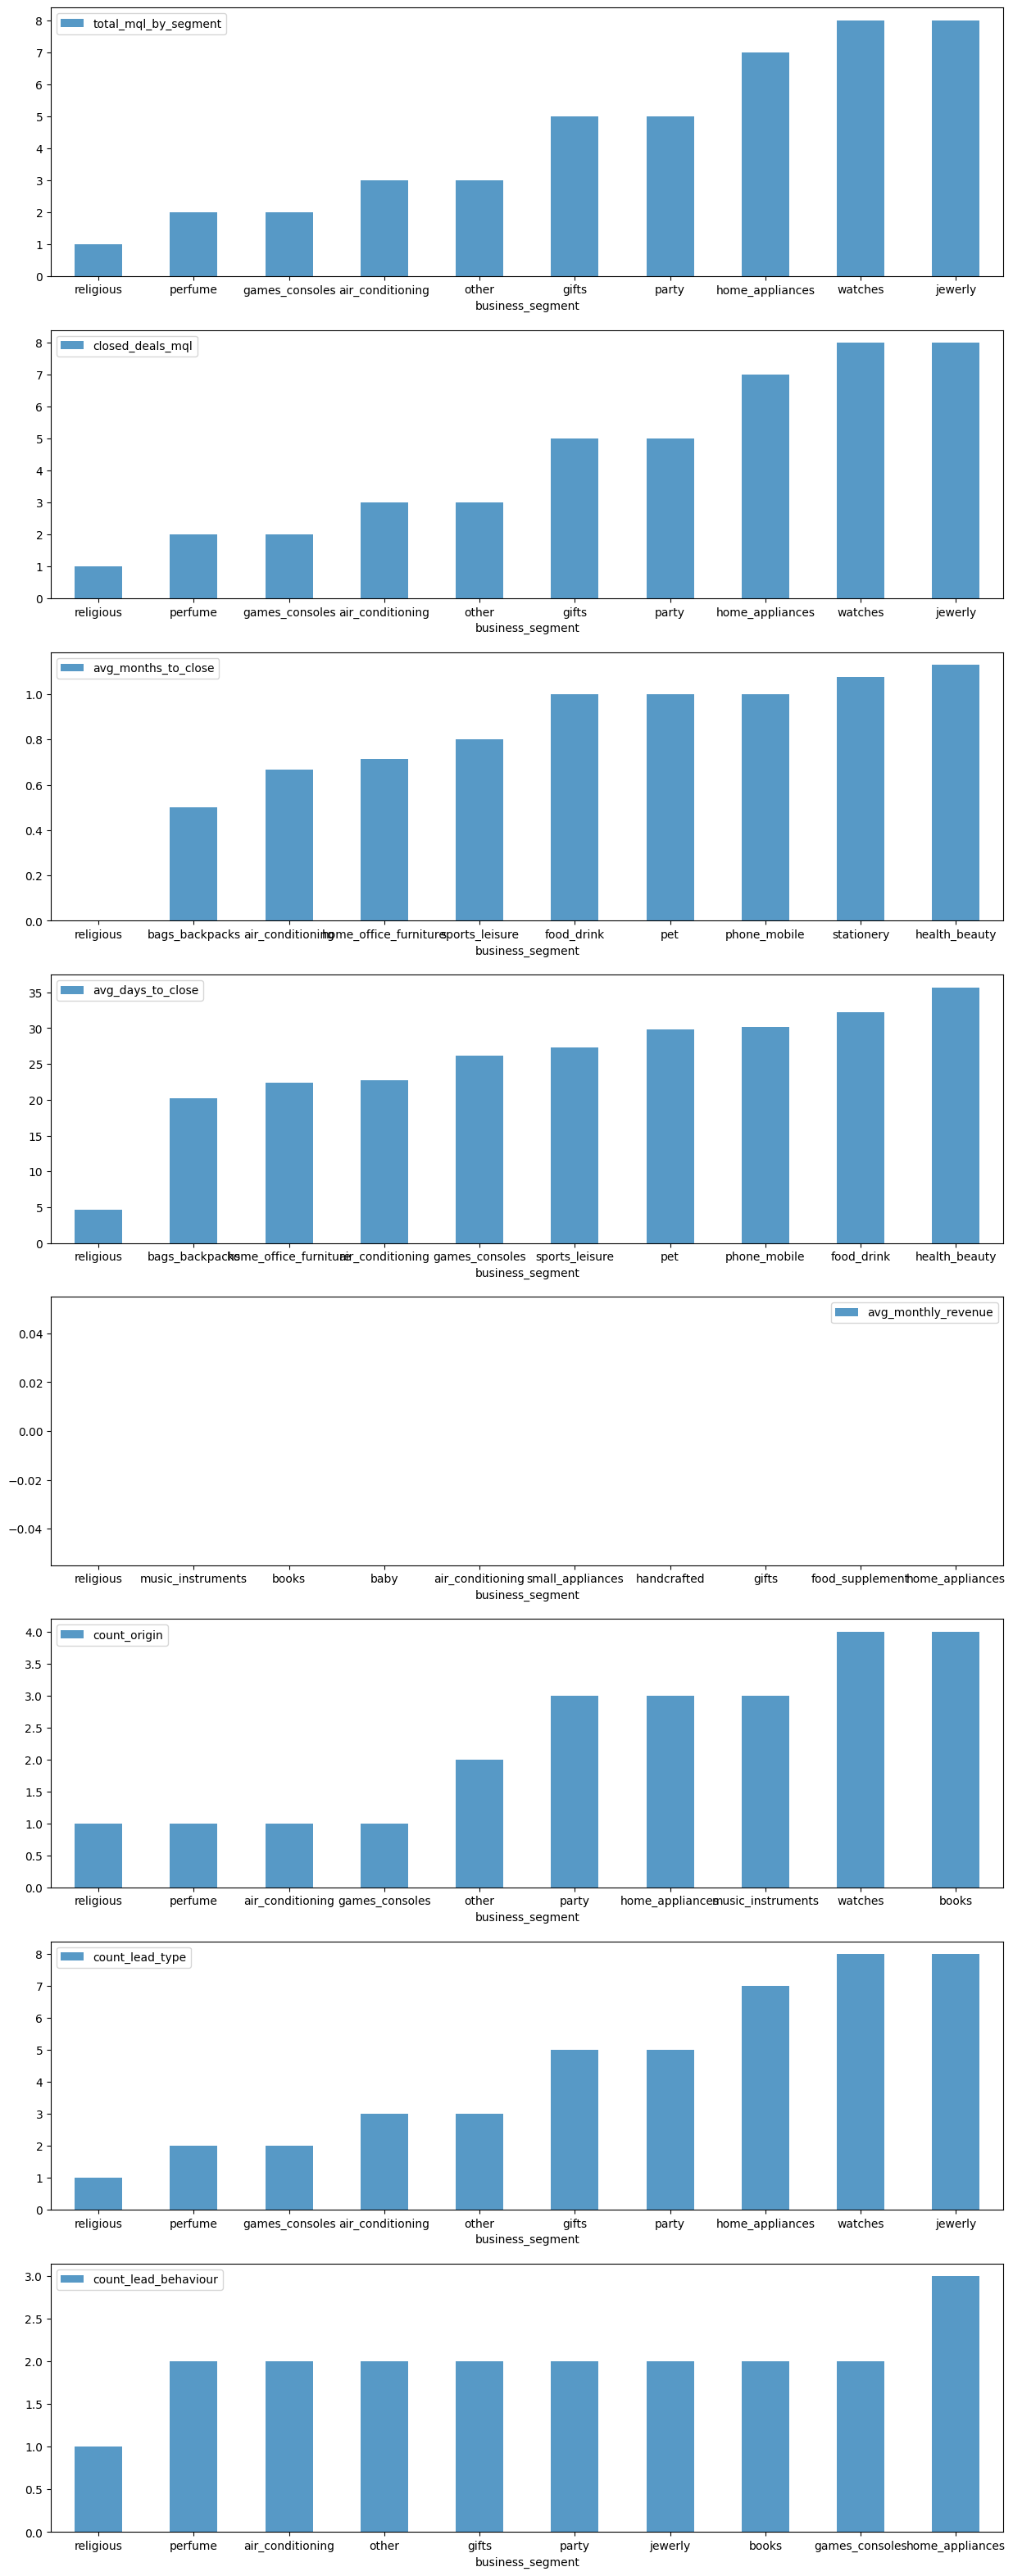

In [60]:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(15,40))
segmentdf.sort_values(by='total_mql_by_segment')[:10].plot(x='business_segment', y='total_mql_by_segment', kind='bar', alpha=0.75, rot=0, ax=axes[0])
segmentdf.sort_values(by='closed_deals_mql')[:10].plot(x='business_segment', y='closed_deals_mql', kind='bar', alpha=0.75, rot=0, ax=axes[1])
segmentdf.sort_values(by='avg_months_to_close')[:10].plot(x='business_segment', y='avg_months_to_close', kind='bar', alpha=0.75, rot=0, ax=axes[2])
segmentdf.sort_values(by='avg_days_to_close')[:10].plot(x='business_segment', y='avg_days_to_close', kind='bar', alpha=0.75, rot=0, ax=axes[3])
segmentdf.sort_values(by='avg_monthly_revenue')[:10].plot(x='business_segment', y='avg_monthly_revenue', kind='bar', alpha=0.75, rot=0, ax=axes[4])
segmentdf.sort_values(by='count_origin')[:10].plot(x='business_segment', y='count_origin', kind='bar', alpha=0.75, rot=0, ax=axes[5])
segmentdf.sort_values(by='count_lead_type')[:10].plot(x='business_segment', y='count_lead_type', kind='bar', alpha=0.75, rot=0, ax=axes[6])
segmentdf.sort_values(by='count_lead_behaviour')[:10].plot(x='business_segment', y='count_lead_behaviour', kind='bar', alpha=0.75, rot=0, ax=axes[7])

## Analyzing leads by business_type

In [61]:
print(f'Number of business types = {alldeals.business_type.nunique()}')

Number of business types = 3


In [62]:
btypedf = alldeals.groupby('business_type').agg(
    closed_deals_mql=('closed','sum'),
    total_mql_by_segment=('mql_id','count'),
    avg_months_to_close=('won_duration_months', 'mean'),
    avg_days_to_close=('won_duration_days', 'mean'),
    avg_monthly_revenue=('declared_monthly_revenue','mean'),
    count_origin=('origin','nunique'),
    count_business_segment=('business_segment','nunique'),
    count_lead_type=('lead_type','count'),
    count_lead_behaviour=('lead_behaviour_profile','nunique'),
)
btypedf = btypedf.sort_values('closed_deals_mql', ascending=False).reset_index()
btypedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_type           3 non-null      object 
 1   closed_deals_mql        3 non-null      float64
 2   total_mql_by_segment    3 non-null      int64  
 3   avg_months_to_close     3 non-null      float64
 4   avg_days_to_close       3 non-null      float64
 5   avg_monthly_revenue     3 non-null      float64
 6   count_origin            3 non-null      int64  
 7   count_business_segment  3 non-null      int64  
 8   count_lead_type         3 non-null      int64  
 9   count_lead_behaviour    3 non-null      int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 368.0+ bytes


In [63]:
btypedf.head()

,business_type,closed_deals_mql,total_mql_by_segment,avg_months_to_close,avg_days_to_close,avg_monthly_revenue,count_origin,count_business_segment,count_lead_type,count_lead_behaviour
0,reseller,587.0,587,1.594549,49.793092,17603.076661,10,31,581,9
1,manufacturer,242.0,242,1.404959,46.069971,210020.661157,9,25,242,6
2,other,3.0,3,8.666667,254.464900,208666.666667,2,1,3,2


<AxesSubplot: title={'center': 'Count lead behaviour'}, ylabel='count_lead_behaviour'>

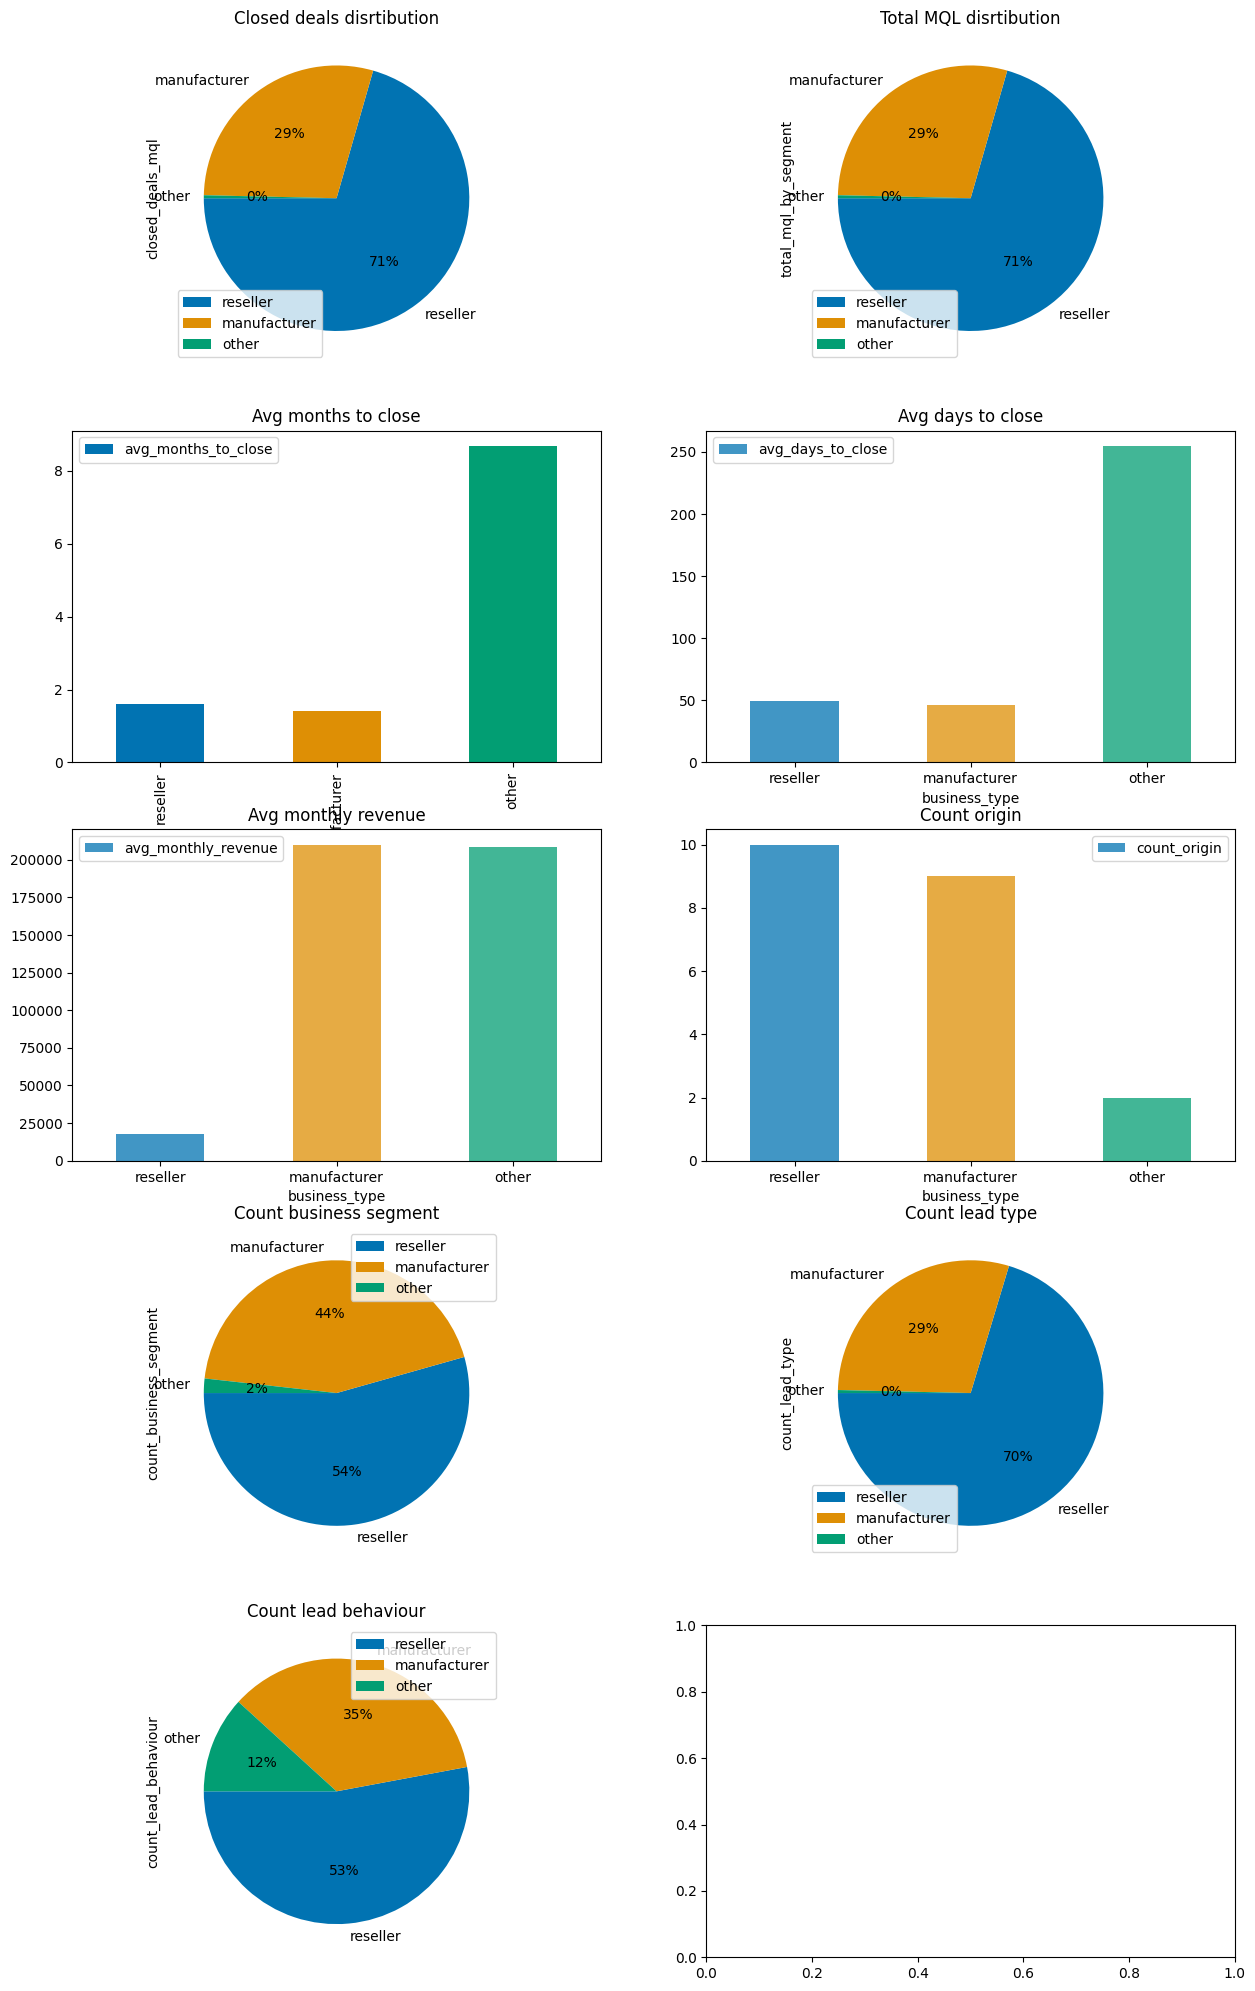

In [98]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,25))
btypedf.plot(kind='pie', y='closed_deals_mql' , title='Closed deals disrtibution', labels=btypedf.business_type, startangle=180, colors = color, autopct='%.0f%%', ax=axes[0, 0])
btypedf.plot(kind='pie', y='total_mql_by_segment' , title='Total MQL disrtibution', labels=btypedf.business_type, startangle=180, colors = color, autopct='%.0f%%', ax=axes[0, 1])
btypedf.plot(kind='bar',x='business_type', y='avg_months_to_close' , title='Avg months to close', color=color, ax=axes[1, 0])
btypedf.plot(kind='bar',x='business_type', y='avg_days_to_close', title='Avg days to close', alpha=0.75, rot=0, color=color, ax=axes[1, 1])
btypedf.plot(kind='bar',x='business_type', y='avg_monthly_revenue', title='Avg monthly revenue', alpha=0.75, rot=0, color=color, ax=axes[2, 0])
btypedf.plot(kind='bar',x='business_type', y='count_origin', title='Count origin', alpha=0.75, rot=0, color=color, ax=axes[2, 1])
btypedf.plot(kind='pie',y='count_business_segment', title='Count business segment', labels=btypedf.business_type, startangle=180, colors = color, autopct='%.0f%%', ax=axes[3, 0])
btypedf.plot(kind='pie',y='count_lead_type', title='Count lead type', labels=btypedf.business_type, startangle=180, colors = color, autopct='%.0f%%', ax=axes[3, 1])
btypedf.plot(kind='pie',y='count_lead_behaviour', title='Count lead behaviour', labels=btypedf.business_type, startangle=180, colors = color, autopct='%.0f%%', ax=axes[4, 0])


## Analyzing leads by lead_type

In [99]:
print(f'Number of lead types = {alldeals.lead_type.nunique()}')

Number of lead types = 8


In [100]:
leadtypedf = alldeals.groupby('lead_type').agg(
    closed_deals_mql=('closed','sum'),
    total_mql_by_leadtype=('mql_id','count'),
    avg_months_to_close=('won_duration_months', 'mean'),
    avg_days_to_close=('won_duration_days', 'mean'),
    avg_monthly_revenue=('declared_monthly_revenue','mean'),
    count_origin=('origin','nunique'),
    count_business_segment=('business_segment','nunique'),
    count_lead_btype=('business_type','count'),
    count_lead_behaviour=('lead_behaviour_profile','nunique'),
)
leadtypedf = leadtypedf.sort_values('closed_deals_mql', ascending=False).reset_index()
leadtypedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lead_type               8 non-null      object 
 1   closed_deals_mql        8 non-null      float64
 2   total_mql_by_leadtype   8 non-null      int64  
 3   avg_months_to_close     8 non-null      float64
 4   avg_days_to_close       8 non-null      float64
 5   avg_monthly_revenue     8 non-null      float64
 6   count_origin            8 non-null      int64  
 7   count_business_segment  8 non-null      int64  
 8   count_lead_btype        8 non-null      int64  
 9   count_lead_behaviour    8 non-null      int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 768.0+ bytes


In [101]:
leadtypedf.head(8)

,lead_type,closed_deals_mql,total_mql_by_leadtype,avg_months_to_close,avg_days_to_close,avg_monthly_revenue,count_origin,count_business_segment,count_lead_btype,count_lead_behaviour
0,online_medium,332.0,332,1.433735,45.449308,1753.012048,10,31,327,7
1,online_big,126.0,126,1.722222,53.854870,71904.761905,9,26,126,6
2,industry,123.0,123,1.463415,47.150849,410609.756098,7,23,120,5
3,offline,104.0,104,1.519231,47.587942,2692.307692,9,24,102,5
4,online_small,77.0,77,1.792208,57.769807,9480.519481,7,21,77,5
5,online_beginner,57.0,57,1.614035,51.865595,17.649123,8,21,57,3
6,online_top,14.0,14,0.642857,22.124797,0.000000,4,11,14,3
7,other,3.0,3,8.666667,254.464900,208666.666667,2,1,3,2


<AxesSubplot: title={'center': 'Count lead behaviour by lead type'}, xlabel='lead_type'>

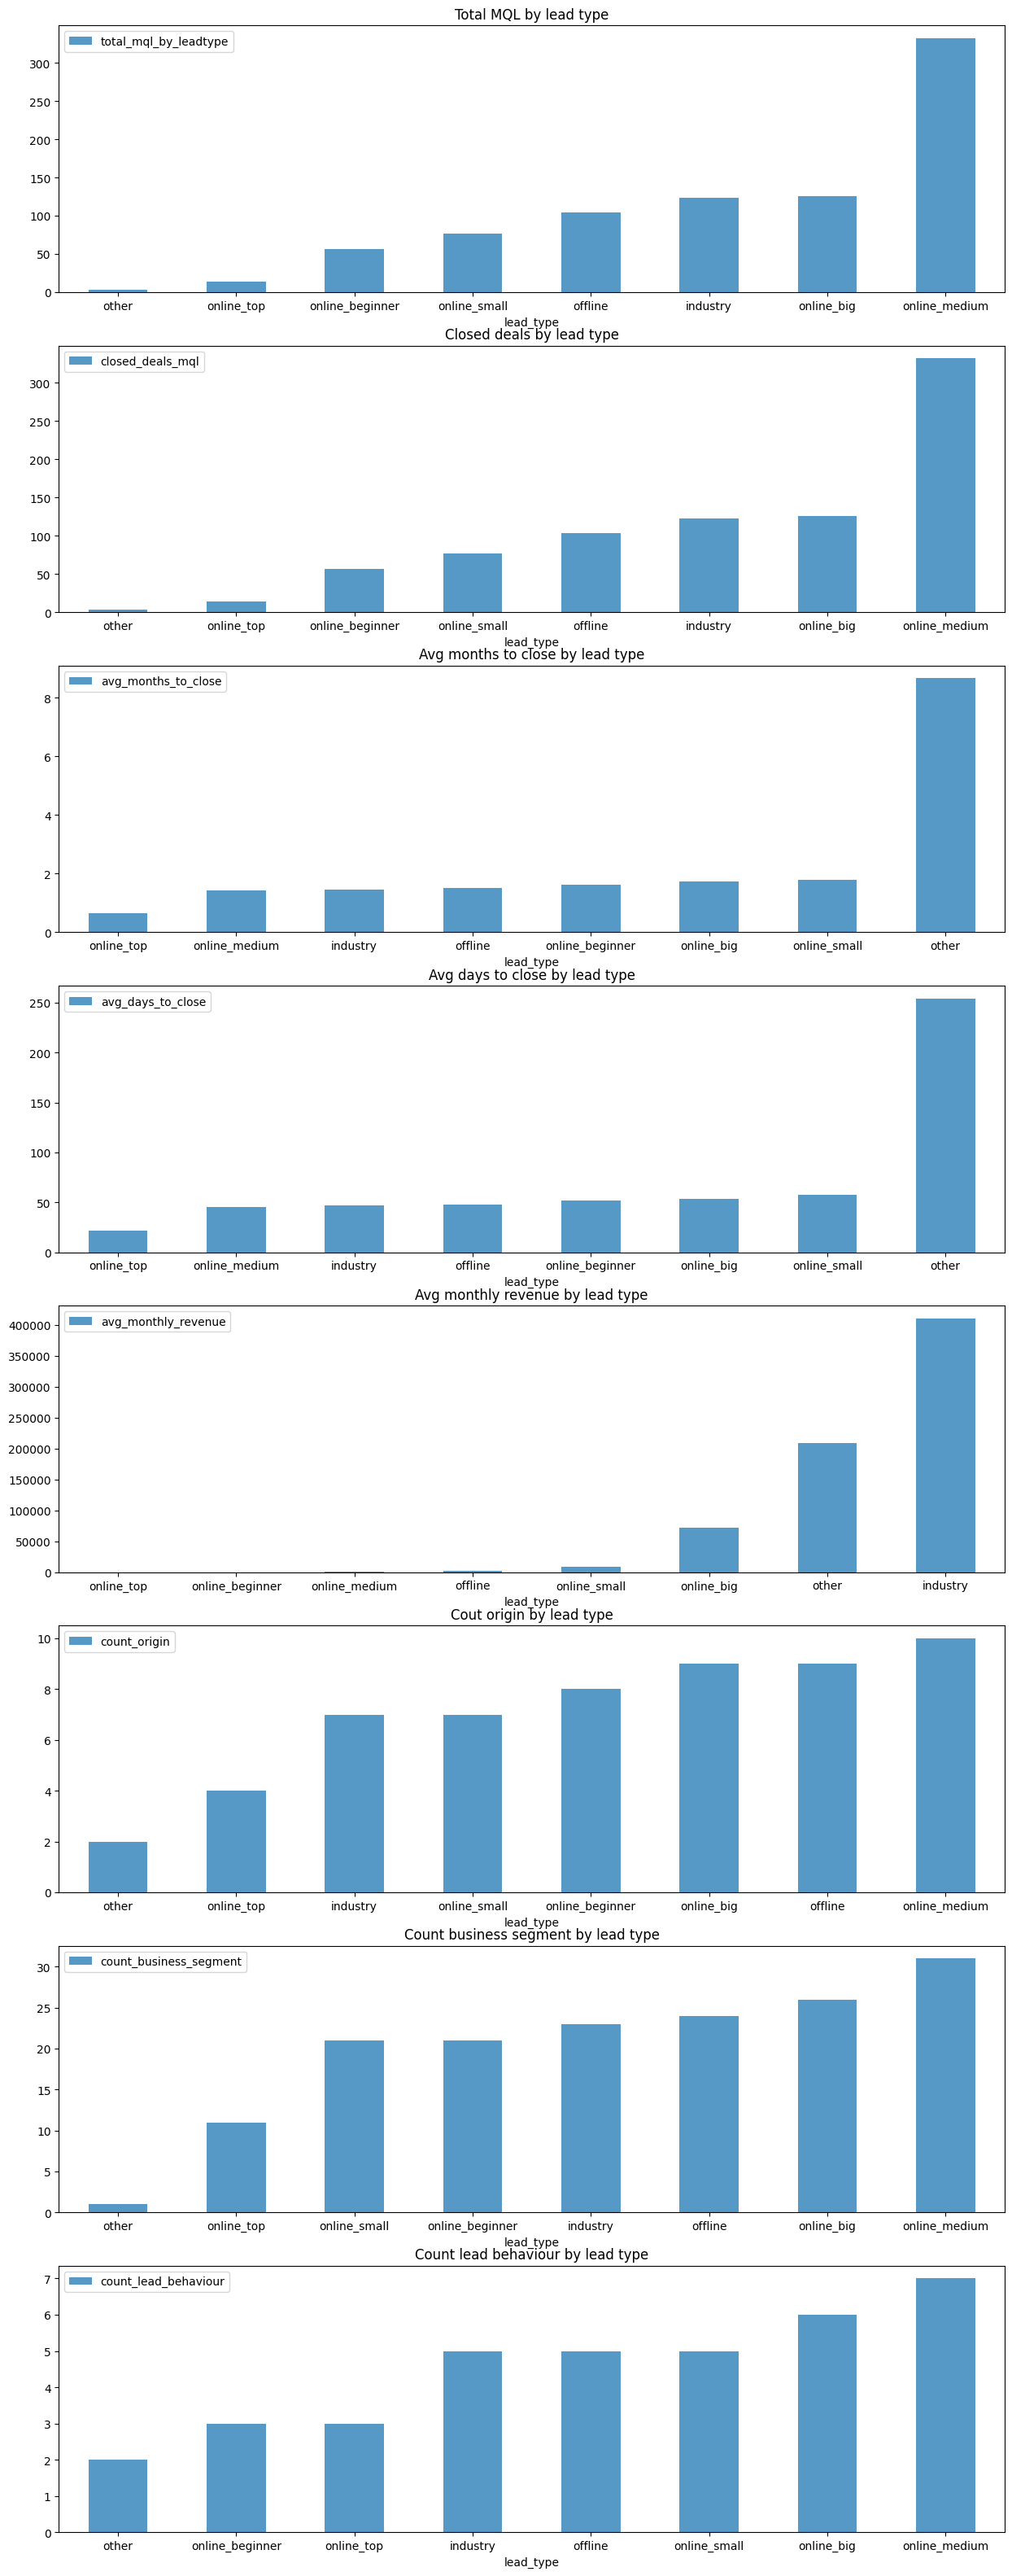

In [107]:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(15,40))
leadtypedf.sort_values(by='total_mql_by_leadtype')[:10].plot(x='lead_type', y='total_mql_by_leadtype', title='Total MQL by lead type', kind='bar', alpha=0.75, rot=0, ax=axes[0])
leadtypedf.sort_values(by='closed_deals_mql')[:10].plot(x='lead_type', y='closed_deals_mql', title='Closed deals by lead type', kind='bar', alpha=0.75, rot=0, ax=axes[1])
leadtypedf.sort_values(by='avg_months_to_close')[:10].plot(x='lead_type', y='avg_months_to_close', title='Avg months to close by lead type', kind='bar', alpha=0.75, rot=0, ax=axes[2])
leadtypedf.sort_values(by='avg_days_to_close')[:10].plot(x='lead_type', y='avg_days_to_close', title='Avg days to close by lead type', kind='bar', alpha=0.75, rot=0, ax=axes[3])
leadtypedf.sort_values(by='avg_monthly_revenue')[:10].plot(x='lead_type', y='avg_monthly_revenue', title='Avg monthly revenue by lead type', kind='bar', alpha=0.75, rot=0, ax=axes[4])
leadtypedf.sort_values(by='count_origin')[:10].plot(x='lead_type', y='count_origin', kind='bar', title='Cout origin by lead type', alpha=0.75, rot=0, ax=axes[5])
leadtypedf.sort_values(by='count_business_segment')[:10].plot(x='lead_type', y='count_business_segment', title='Count business segment by lead type', kind='bar', alpha=0.75, rot=0, ax=axes[6])
leadtypedf.sort_values(by='count_lead_behaviour')[:10].plot(x='lead_type', y='count_lead_behaviour', title='Count lead behaviour by lead type', kind='bar', alpha=0.75, rot=0, ax=axes[7])

## Analyzing leads by lead behaviour profile

In [108]:
print(f'Number of lead behaviour profiles = {alldeals.lead_behaviour_profile.nunique()}')

Number of lead behaviour profiles = 9


In [109]:
leadbeaviourdf = alldeals.groupby('lead_behaviour_profile').agg(
    closed_deals_mql=('closed','sum'),
    total_mql_by_leadbehaviour=('mql_id','count'),
    avg_months_to_close=('won_duration_months', 'mean'),
    avg_days_to_close=('won_duration_days', 'mean'),
    avg_monthly_revenue=('declared_monthly_revenue','mean'),
    count_origin=('origin','nunique'),
    count_business_segment=('business_segment','nunique'),
    count_lead_btype=('business_type','count'),
    count_lead_type=('lead_type','nunique'),
)
leadbeaviourdf = leadbeaviourdf.sort_values('closed_deals_mql', ascending=False).reset_index()
leadbeaviourdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lead_behaviour_profile      9 non-null      object 
 1   closed_deals_mql            9 non-null      float64
 2   total_mql_by_leadbehaviour  9 non-null      int64  
 3   avg_months_to_close         9 non-null      float64
 4   avg_days_to_close           9 non-null      float64
 5   avg_monthly_revenue         9 non-null      float64
 6   count_origin                9 non-null      int64  
 7   count_business_segment      9 non-null      int64  
 8   count_lead_btype            9 non-null      int64  
 9   count_lead_type             9 non-null      int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 848.0+ bytes


In [110]:
leadbeaviourdf.head(9)

,lead_behaviour_profile,closed_deals_mql,total_mql_by_leadbehaviour,avg_months_to_close,avg_days_to_close,avg_monthly_revenue,count_origin,count_business_segment,count_lead_btype,count_lead_type
0,cat,407.0,407,1.297297,41.353845,126319.410319,10,32,402,8
1,eagle,123.0,123,1.130081,36.652738,276.422764,9,27,120,7
2,wolf,95.0,95,2.715789,84.589949,13210.526316,8,26,95,6
3,shark,24.0,24,2.416667,76.134396,357500.000000,5,11,23,6
4,"cat, wolf",8.0,8,6.125000,186.430864,13500.000000,3,7,8,3
5,"eagle, cat",3.0,3,6.666667,199.650382,25000.000000,2,2,3,2
6,"eagle, wolf",3.0,3,5.000000,150.138032,40000.000000,2,3,3,2
7,"shark, cat",1.0,1,6.000000,181.521829,0.000000,1,1,1,1
8,"shark, wolf",1.0,1,11.000000,341.522396,60000.000000,1,1,1,1


<AxesSubplot: title={'center': 'Count lead behaviour by lead behaviour profile'}, xlabel='lead_behaviour_profile'>

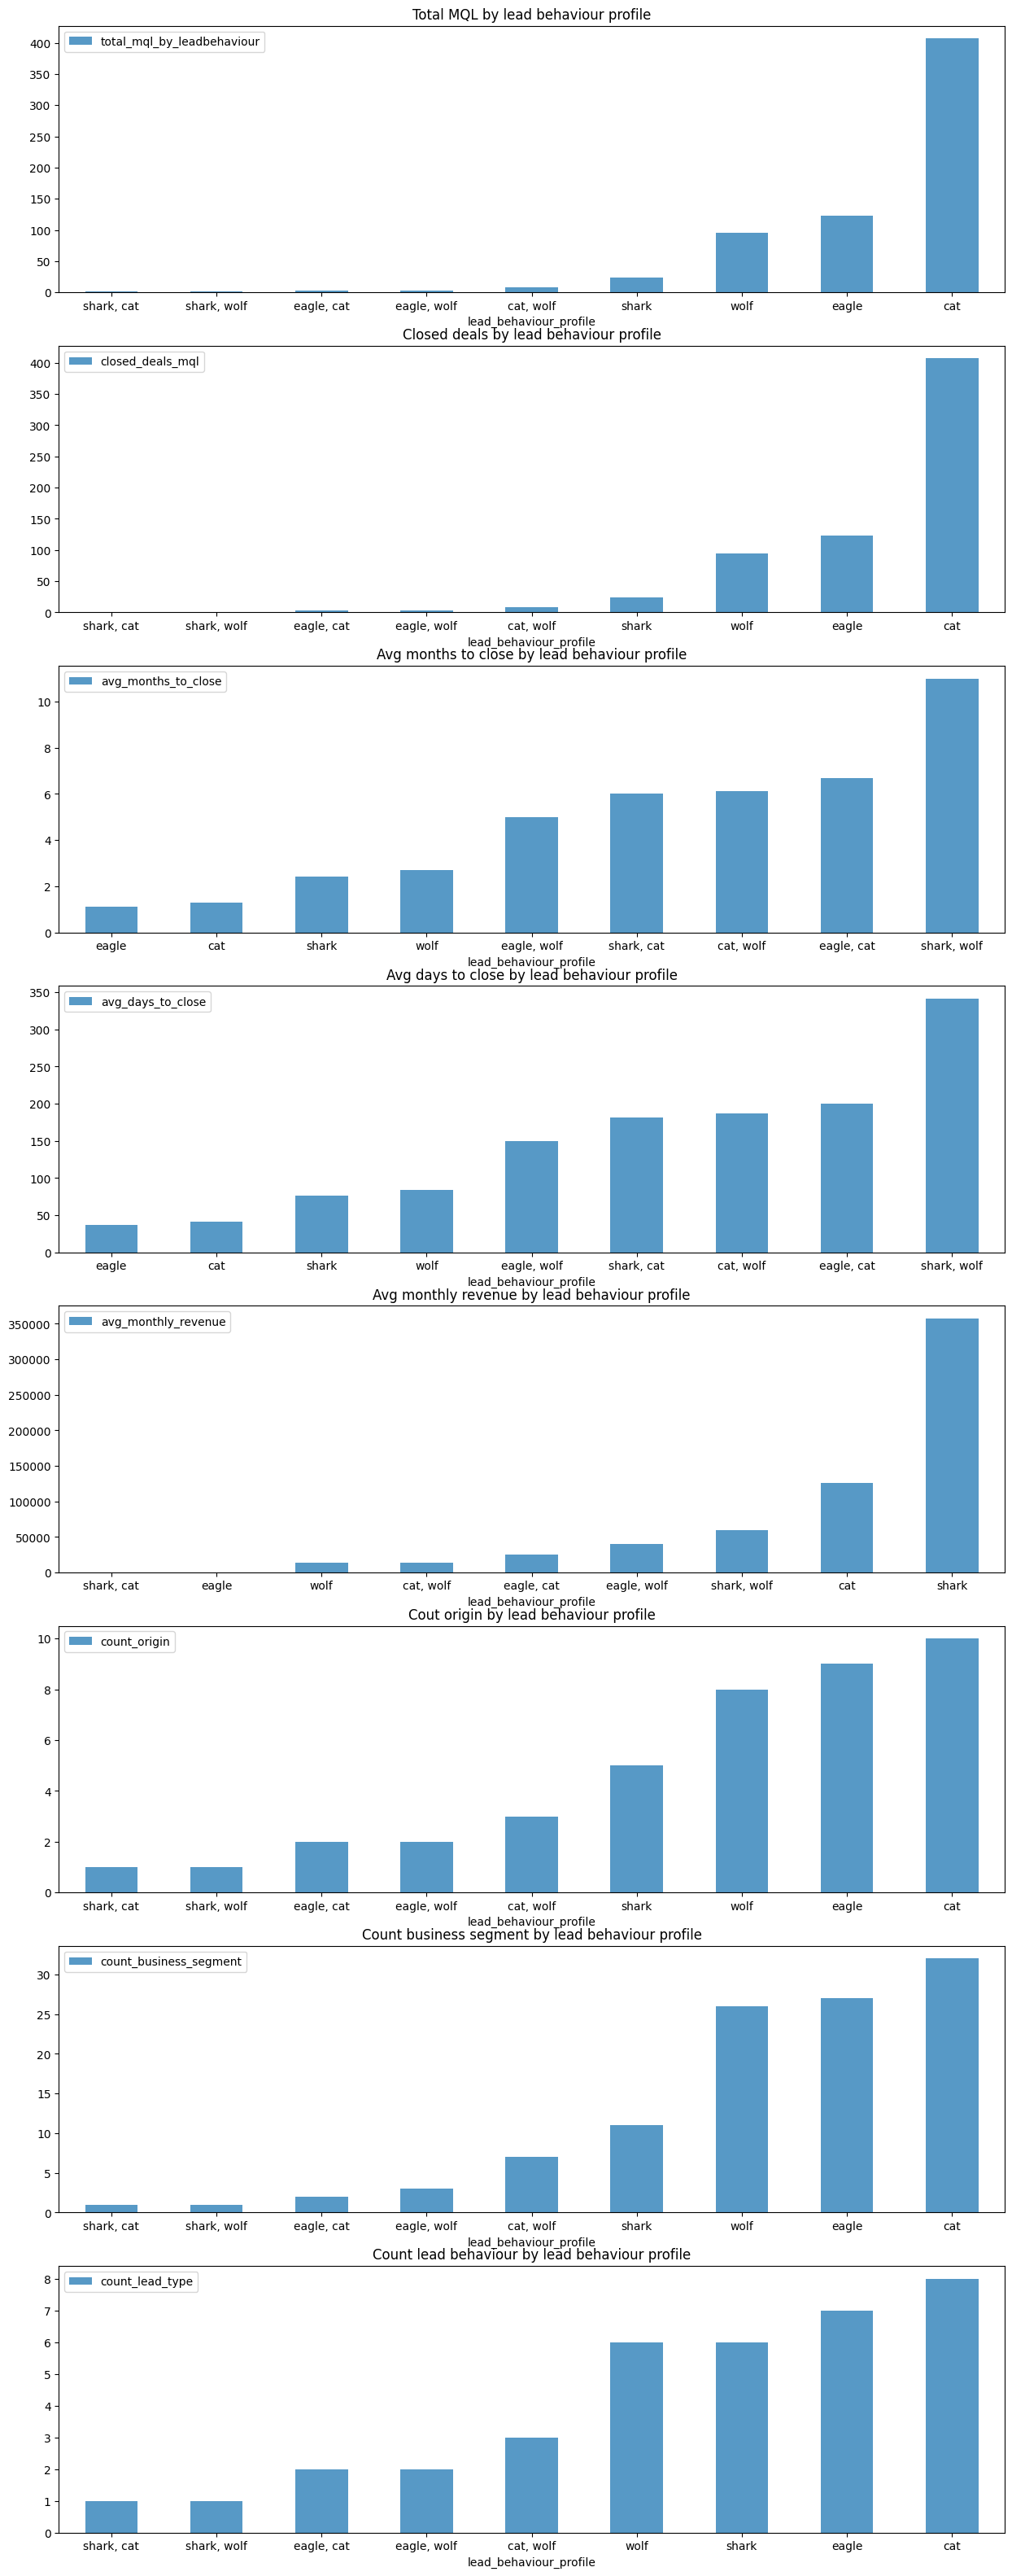

In [111]:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(15,40))
leadbeaviourdf.sort_values(by='total_mql_by_leadbehaviour')[:10].plot(x='lead_behaviour_profile', y='total_mql_by_leadbehaviour', title='Total MQL by lead behaviour profile', kind='bar', alpha=0.75, rot=0, ax=axes[0])
leadbeaviourdf.sort_values(by='closed_deals_mql')[:10].plot(x='lead_behaviour_profile', y='closed_deals_mql', title='Closed deals by lead behaviour profile', kind='bar', alpha=0.75, rot=0, ax=axes[1])
leadbeaviourdf.sort_values(by='avg_months_to_close')[:10].plot(x='lead_behaviour_profile', y='avg_months_to_close', title='Avg months to close by lead behaviour profile', kind='bar', alpha=0.75, rot=0, ax=axes[2])
leadbeaviourdf.sort_values(by='avg_days_to_close')[:10].plot(x='lead_behaviour_profile', y='avg_days_to_close', title='Avg days to close by lead behaviour profile', kind='bar', alpha=0.75, rot=0, ax=axes[3])
leadbeaviourdf.sort_values(by='avg_monthly_revenue')[:10].plot(x='lead_behaviour_profile', y='avg_monthly_revenue', title='Avg monthly revenue by lead behaviour profile', kind='bar', alpha=0.75, rot=0, ax=axes[4])
leadbeaviourdf.sort_values(by='count_origin')[:10].plot(x='lead_behaviour_profile', y='count_origin', kind='bar', title='Cout origin by lead behaviour profile', alpha=0.75, rot=0, ax=axes[5])
leadbeaviourdf.sort_values(by='count_business_segment')[:10].plot(x='lead_behaviour_profile', y='count_business_segment', title='Count business segment by lead behaviour profile', kind='bar', alpha=0.75, rot=0, ax=axes[6])
leadbeaviourdf.sort_values(by='count_lead_type')[:10].plot(x='lead_behaviour_profile', y='count_lead_type', title='Count lead behaviour by lead behaviour profile', kind='bar', alpha=0.75, rot=0, ax=axes[7])

## Analyzing leads by won month

In [137]:
wondurationdf1 = alldeals.groupby(pd.Grouper(key='won_date',freq='M')).agg(
    closed_deals_mql=('closed','sum'),
    total_mql_by_wonmonth=('mql_id','count'),
    avg_months_to_close=('won_duration_months', 'mean'),
    avg_days_to_close=('won_duration_days', 'mean'),
    avg_monthly_revenue=('declared_monthly_revenue','mean'),
    count_origin=('origin','nunique'),
    count_business_segment=('business_segment','nunique'),
    count_lead_btype=('business_type','count'),
    count_lead_type=('lead_type','nunique'),
    count_lead_behaviours=('lead_behaviour_profile','nunique')
)
wondurationdf1 = wondurationdf1.reset_index()
wondurationdf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   won_date                12 non-null     datetime64[ns]
 1   closed_deals_mql        12 non-null     float64       
 2   total_mql_by_wonmonth   12 non-null     int64         
 3   avg_months_to_close     12 non-null     float64       
 4   avg_days_to_close       12 non-null     float64       
 5   avg_monthly_revenue     12 non-null     float64       
 6   count_origin            12 non-null     int64         
 7   count_business_segment  12 non-null     int64         
 8   count_lead_btype        12 non-null     int64         
 9   count_lead_type         12 non-null     int64         
 10  count_lead_behaviours   12 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(6)
memory usage: 1.2 KB


In [138]:
wondurationdf1.head(12)

,won_date,closed_deals_mql,total_mql_by_wonmonth,avg_months_to_close,avg_days_to_close,avg_monthly_revenue,count_origin,count_business_segment,count_lead_btype,count_lead_type,count_lead_behaviours
0,2017-12-31,3.0,3,0.666667,13.105938,0.000000e+00,2,3,3,3,0
1,2018-01-31,73.0,73,0.273973,16.875555,0.000000e+00,7,24,73,7,0
2,2018-02-28,113.0,113,0.504425,16.554598,0.000000e+00,9,27,110,6,3
3,2018-03-31,147.0,147,0.578231,18.326102,0.000000e+00,10,26,146,7,4
4,2018-04-30,207.0,207,0.763285,26.947281,0.000000e+00,10,28,203,7,4
5,2018-05-31,122.0,122,0.942623,29.743404,0.000000e+00,9,24,121,7,4
6,2018-06-30,57.0,57,2.543860,73.727970,0.000000e+00,6,21,57,7,7
7,2018-07-31,37.0,37,4.621622,139.821087,0.000000e+00,6,18,36,6,4
8,2018-08-31,33.0,33,5.878788,181.064026,2.912139e+04,6,18,33,6,8
9,2018-09-30,23.0,23,6.217391,189.930828,4.043478e+05,4,12,23,5,5


<AxesSubplot: xlabel='won_date'>

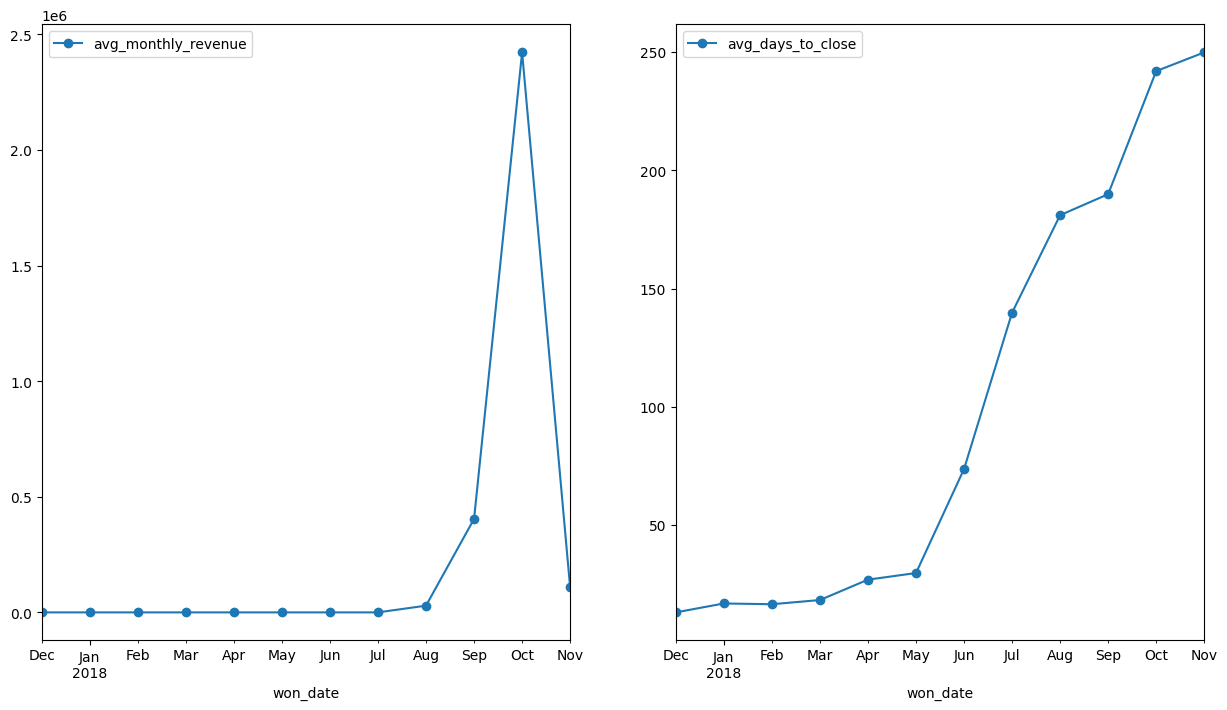

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

wondurationdf1.plot(x='won_date', y='avg_monthly_revenue', marker="o", ax=axes[0])
wondurationdf1.plot(x='won_date', y='avg_days_to_close', marker="o", ax=axes[1])

KeyError: 'avg_monthly_revenue'

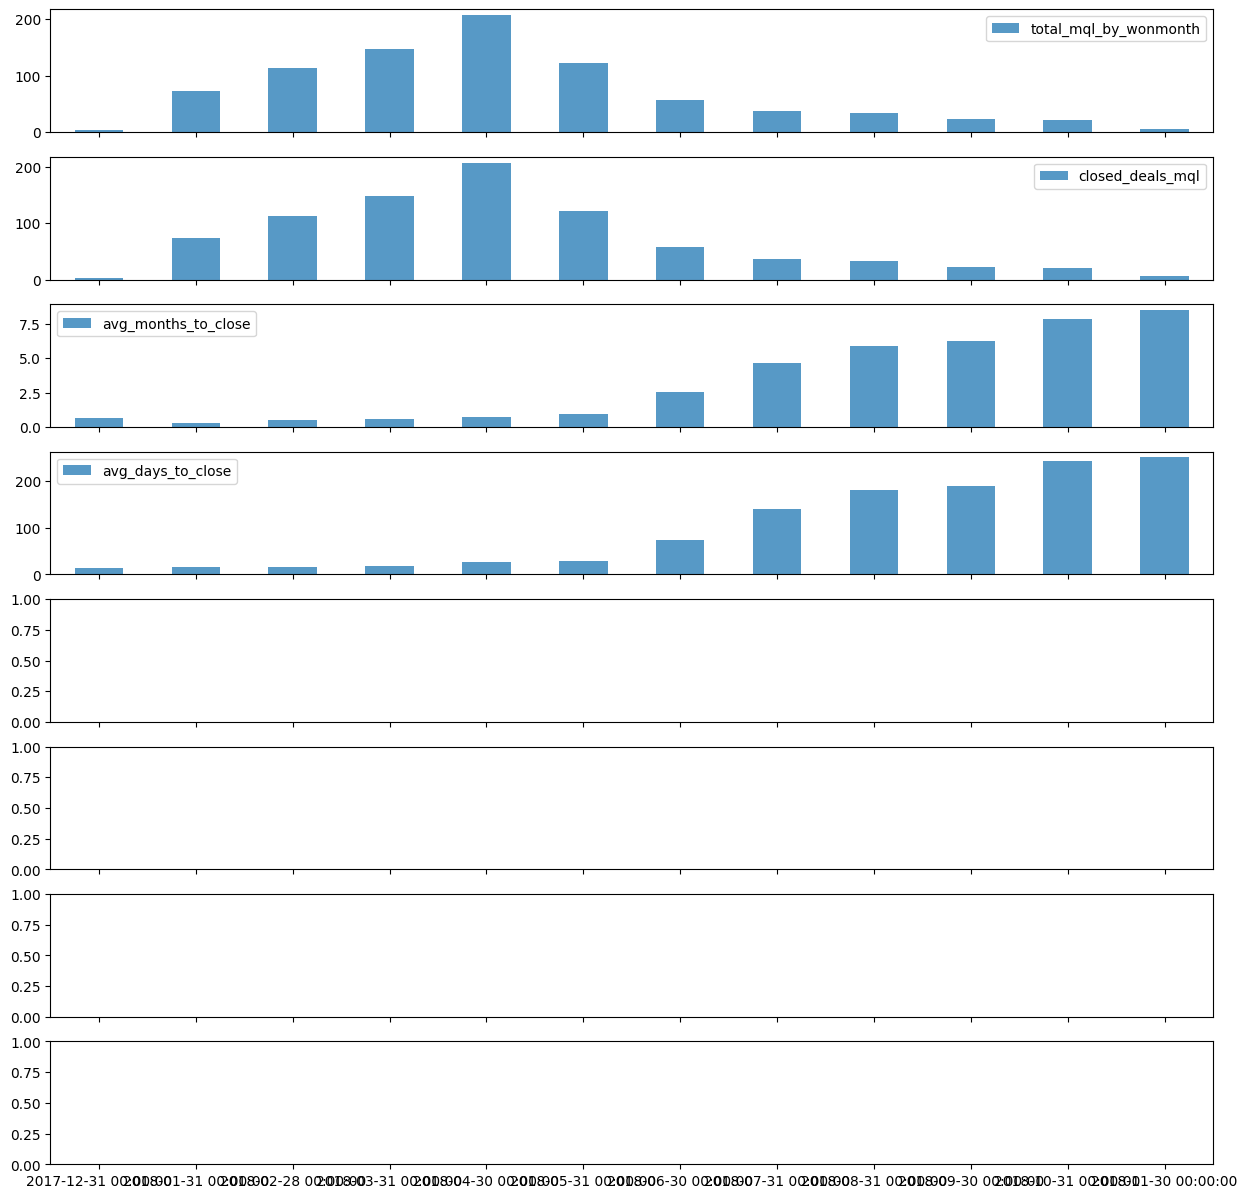

In [131]:
fig, axes = plt.subplots(nrows=8, ncols=1, sharex=True, figsize=(15,15))
wondurationdf1.plot(x='won_date', y='total_mql_by_wonmonth', kind='bar', alpha=0.75, rot=90, ax=axes[0])
wondurationdf1.plot(x='won_date', y='closed_deals_mql', kind='bar', alpha=0.75, rot=90, ax=axes[1])
wondurationdf1.plot(x='won_date', y='avg_months_to_close', kind='bar', alpha=0.75, rot=90, ax=axes[2])
wondurationdf1.plot(x='won_date', y='avg_days_to_close', kind='bar', alpha=0.75, rot=90, ax=axes[3])
wondurationdf1.plot(x='won_date', y='avg_monthly_revenue', kind='bar', alpha=0.75, rot=90, ax=axes[4])
wondurationdf1.plot(x='won_date', y='count_business_segment', kind='bar', alpha=0.75, rot=90, ax=axes[5])
wondurationdf1.plot(x='won_date', y='count_lead_type', kind='bar', alpha=0.75, rot=90, ax=axes[6])
wondurationdf1.plot(x='won_date', y='count_lead_behaviour', kind='bar', alpha=0.75, rot=90, ax=axes[7])

## Analyzing leads by declared monthly revenue

In [112]:
monthlyrevenuedf = alldeals.groupby('declared_monthly_revenue').agg(
    closed_deals_mql=('closed','sum'),
    total_mql_by_monthlyrev=('mql_id','count'),
    avg_months_to_close=('won_duration_months', 'mean'),
    avg_days_to_close=('won_duration_days', 'mean'),
    count_origin=('origin','nunique'),
    count_business_segment=('business_segment','nunique'),
    count_lead_btype=('business_type','count'),
    count_lead_type=('lead_type','nunique'),
)
monthlyrevenuedf = monthlyrevenuedf.sort_values('closed_deals_mql', ascending=False).reset_index()
monthlyrevenuedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   declared_monthly_revenue  27 non-null     float64
 1   closed_deals_mql          27 non-null     float64
 2   total_mql_by_monthlyrev   27 non-null     int64  
 3   avg_months_to_close       27 non-null     float64
 4   avg_days_to_close         27 non-null     float64
 5   count_origin              27 non-null     int64  
 6   count_business_segment    27 non-null     int64  
 7   count_lead_btype          27 non-null     int64  
 8   count_lead_type           27 non-null     int64  
dtypes: float64(4), int64(5)
memory usage: 2.0 KB


In [115]:
monthlyrevenuedf.describe()

,declared_monthly_revenue,closed_deals_mql,total_mql_by_monthlyrev,avg_months_to_close,avg_days_to_close,count_origin,count_business_segment,count_lead_btype,count_lead_type
count,2.700000e+01,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,2.237556e+06,31.185185,31.185185,7.483580,229.447198,1.777778,2.814815,30.814815,1.555556
std,9.666383e+06,153.052791,153.052791,2.719629,81.986688,1.761410,5.896786,151.128330,1.219500
min,0.000000e+00,1.000000,1.000000,1.223338,39.109995,0.000000,1.000000,1.000000,1.000000
25%,9.000000e+03,1.000000,1.000000,5.750000,183.468056,1.000000,1.000000,1.000000,1.000000
50%,5.000000e+04,1.000000,1.000000,7.000000,210.879028,1.000000,1.000000,1.000000,1.000000
75%,1.900000e+05,2.000000,2.000000,9.250000,279.708131,2.000000,2.000000,2.000000,2.000000
max,5.000000e+07,797.000000,797.000000,14.000000,427.551817,10.000000,32.000000,787.000000,7.000000


<AxesSubplot: title={'center': 'Count lead behaviour by lead behaviour profile'}, xlabel='declared_monthly_revenue'>

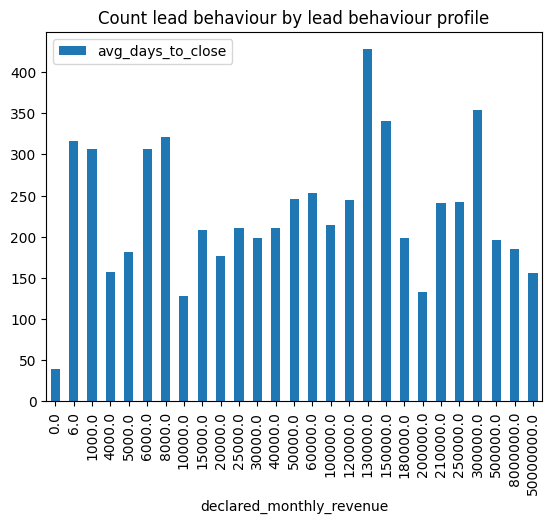

In [118]:
monthlyrevenuedf.sort_values(by='declared_monthly_revenue').plot(kind='bar', x='declared_monthly_revenue', y='avg_days_to_close', title='Count lead behaviour by lead behaviour profile')

# Predictive model

In [2]:
mql_df = pd.read_feather('./data/mql_df.feather')
closed_deals = pd.read_feather('./data/closed_deals.feather')
closed_merged = pd.read_feather('./data/closed_merged.feather')
alldeals = pd.read_feather('./data/alldeals.feather')

In [3]:
train1 = alldeals.copy()
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date             8000 non-null   datetime64[ns]
 2   landing_page_id                8000 non-null   object        
 3   origin                         7940 non-null   object        
 4   first_contact_year             8000 non-null   int64         
 5   first_contact_month            8000 non-null   int64         
 6   first_contact_day              8000 non-null   int64         
 7   first_contact_day_week         8000 non-null   int64         
 8   seller_id                      842 non-null    object        
 9   sdr_id                         842 non-null    object        
 10  sr_id                          842 non-null    object        
 11  won_date         

In [4]:
encoder= ce.BinaryEncoder(cols=['mql_id', 'landing_page_id', 'origin', 'seller_id', 'sdr_id', 'sr_id', 
        'business_segment', 'lead_type', 'lead_behaviour_profile', 'has_company', 'has_gtin', 'average_stock',
       'business_type'],return_df=True)

In [5]:
tempalldeals = train1.copy()

In [6]:
temp = encoder.fit_transform(tempalldeals)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id_0                       8000 non-null   int64         
 1   mql_id_1                       8000 non-null   int64         
 2   mql_id_2                       8000 non-null   int64         
 3   mql_id_3                       8000 non-null   int64         
 4   mql_id_4                       8000 non-null   int64         
 5   mql_id_5                       8000 non-null   int64         
 6   mql_id_6                       8000 non-null   int64         
 7   mql_id_7                       8000 non-null   int64         
 8   mql_id_8                       8000 non-null   int64         
 9   mql_id_9                       8000 non-null   int64         
 10  mql_id_10                      8000 non-null   int64         
 11  mql_id_11        

In [7]:
temp = temp.drop(['first_contact_date', 'won_date', 'won_duration_days', 'won_duration_months', 'won_year', 'won_month', 'won_day',
       'won_day_week'], axis=1)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id_0                       8000 non-null   int64  
 1   mql_id_1                       8000 non-null   int64  
 2   mql_id_2                       8000 non-null   int64  
 3   mql_id_3                       8000 non-null   int64  
 4   mql_id_4                       8000 non-null   int64  
 5   mql_id_5                       8000 non-null   int64  
 6   mql_id_6                       8000 non-null   int64  
 7   mql_id_7                       8000 non-null   int64  
 8   mql_id_8                       8000 non-null   int64  
 9   mql_id_9                       8000 non-null   int64  
 10  mql_id_10                      8000 non-null   int64  
 11  mql_id_11                      8000 non-null   int64  
 12  mql_id_12                      8000 non-null   i

In [8]:
temp = reduce_memory(temp)
temp.info()

NameError: name 'reduce_memory' is not defined

In [9]:
temp.columns

Index(['mql_id_0', 'mql_id_1', 'mql_id_2', 'mql_id_3', 'mql_id_4', 'mql_id_5',
       'mql_id_6', 'mql_id_7', 'mql_id_8', 'mql_id_9', 'mql_id_10',
       'mql_id_11', 'mql_id_12', 'landing_page_id_0', 'landing_page_id_1',
       'landing_page_id_2', 'landing_page_id_3', 'landing_page_id_4',
       'landing_page_id_5', 'landing_page_id_6', 'landing_page_id_7',
       'landing_page_id_8', 'origin_0', 'origin_1', 'origin_2', 'origin_3',
       'first_contact_year', 'first_contact_month', 'first_contact_day',
       'first_contact_day_week', 'seller_id_0', 'seller_id_1', 'seller_id_2',
       'seller_id_3', 'seller_id_4', 'seller_id_5', 'seller_id_6',
       'seller_id_7', 'seller_id_8', 'seller_id_9', 'sdr_id_0', 'sdr_id_1',
       'sdr_id_2', 'sdr_id_3', 'sdr_id_4', 'sdr_id_5', 'sr_id_0', 'sr_id_1',
       'sr_id_2', 'sr_id_3', 'sr_id_4', 'business_segment_0',
       'business_segment_1', 'business_segment_2', 'business_segment_3',
       'business_segment_4', 'business_segment_5', 'lead

In [10]:
temp['closed'] = temp['closed'].fillna(0)

In [29]:
'''durationnulllist = ['won_year', 'won_month', 'won_day', 'won_day_week', 'closed', 
    'won_duration_days', 'won_duration_months']
temp[durationnulllist] = temp[durationnulllist].fillna(value=1000)
'''    

In [11]:
temp['declared_monthly_revenue'] = temp['declared_monthly_revenue'].fillna(value=0)
temp['declared_product_catalog_size'] = temp['declared_product_catalog_size'].fillna(value=0)

In [12]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id_0                       8000 non-null   int64  
 1   mql_id_1                       8000 non-null   int64  
 2   mql_id_2                       8000 non-null   int64  
 3   mql_id_3                       8000 non-null   int64  
 4   mql_id_4                       8000 non-null   int64  
 5   mql_id_5                       8000 non-null   int64  
 6   mql_id_6                       8000 non-null   int64  
 7   mql_id_7                       8000 non-null   int64  
 8   mql_id_8                       8000 non-null   int64  
 9   mql_id_9                       8000 non-null   int64  
 10  mql_id_10                      8000 non-null   int64  
 11  mql_id_11                      8000 non-null   int64  
 12  mql_id_12                      8000 non-null   i

In [13]:
temp.describe()

,mql_id_0,mql_id_1,mql_id_2,mql_id_3,mql_id_4,mql_id_5,mql_id_6,mql_id_7,mql_id_8,mql_id_9,mql_id_10,mql_id_11,mql_id_12,landing_page_id_0,landing_page_id_1,landing_page_id_2,landing_page_id_3,landing_page_id_4,landing_page_id_5,landing_page_id_6,landing_page_id_7,landing_page_id_8,origin_0,origin_1,origin_2,origin_3,first_contact_year,first_contact_month,first_contact_day,first_contact_day_week,seller_id_0,seller_id_1,seller_id_2,seller_id_3,seller_id_4,seller_id_5,seller_id_6,seller_id_7,seller_id_8,seller_id_9,sdr_id_0,sdr_id_1,sdr_id_2,sdr_id_3,sdr_id_4,sdr_id_5,sr_id_0,sr_id_1,sr_id_2,sr_id_3,sr_id_4,business_segment_0,business_segment_1,business_segment_2,business_segment_3,business_segment_4,business_segment_5,lead_type_0,lead_type_1,lead_type_2,lead_type_3,lead_behaviour_profile_0,lead_behaviour_profile_1,lead_behaviour_profile_2,lead_behaviour_profile_3,has_company_0,has_company_1,has_gtin_0,has_gtin_1,average_stock_0,average_stock_1,average_stock_2,business_type_0,business_type_1,business_type_2,declared_product_catalog_size,declared_monthly_revenue,closed
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8.000000e+03,8000.000000
mean,0.488125,0.488125,0.488125,0.488125,0.488125,0.496000,0.496125,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.045875,0.108625,0.167500,0.321625,0.415250,0.435500,0.439750,0.519750,0.431250,0.049125,0.296875,0.61000,0.681750,2017.749750,4.711250,15.896750,2.364625,0.041500,0.041500,0.04800,0.049500,0.052000,0.052000,0.052500,0.052500,0.052750,0.947375,0.00025,0.00800,0.052125,0.061750,0.062625,0.938625,0.007375,0.042875,0.048875,0.059125,0.937125,0.001000,0.026625,0.053125,0.057375,0.059875,0.948125,0.007500,0.040125,0.071625,0.922625,0.000625,0.016250,0.067750,0.936000,0.007875,0.992750,0.00800,0.993250,0.006000,0.004625,0.994375,0.000375,0.103625,0.92625,2.009875,7.723001e+03,0.105250
std,0.499890,0.499890,0.499890,0.499890,0.499890,0.500015,0.500016,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.209227,0.311188,0.373445,0.467129,0.492796,0.495853,0.496388,0.499641,0.495282,0.216142,0.456910,0.48778,0.465826,0.433184,3.133385,8.729182,1.787617,0.199456,0.199456,0.21378,0.216923,0.222041,0.222041,0.223047,0.223047,0.223548,0.223298,0.01581,0.08909,0.222293,0.240716,0.242302,0.240032,0.085566,0.202588,0.215620,0.235873,0.242753,0.031609,0.160995,0.224297,0.232572,0.237270,0.221788,0.086283,0.196265,0.257882,0.267202,0.024994,0.126443,0.251332,0.244768,0.088397,0.084843,0.08909,0.081886,0.077232,0.067854,0.074793,0.019362,0.304793,0.26138,38.986819,5.661993e+05,0.306894
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [14]:
train1 = temp.copy()
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id_0                       8000 non-null   int64  
 1   mql_id_1                       8000 non-null   int64  
 2   mql_id_2                       8000 non-null   int64  
 3   mql_id_3                       8000 non-null   int64  
 4   mql_id_4                       8000 non-null   int64  
 5   mql_id_5                       8000 non-null   int64  
 6   mql_id_6                       8000 non-null   int64  
 7   mql_id_7                       8000 non-null   int64  
 8   mql_id_8                       8000 non-null   int64  
 9   mql_id_9                       8000 non-null   int64  
 10  mql_id_10                      8000 non-null   int64  
 11  mql_id_11                      8000 non-null   int64  
 12  mql_id_12                      8000 non-null   i

In [15]:
label = 'closed'
x_cols = temp.columns.drop('closed')

In [16]:
X = temp[x_cols]
y = temp[label]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6000, 77) (6000,)
(2000, 77) (2000,)


In [18]:
y_train.value_counts()

0.0    5368
1.0     632
Name: closed, dtype: int64

In [19]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

9.0

In [20]:
y_test.value_counts()

0.0    1790
1.0     210
Name: closed, dtype: int64

In [21]:
y_test.value_counts()

0.0    1790
1.0     210
Name: closed, dtype: int64

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

c:\Users\harsh\Desktop\portfolio\envs\leadschool1\lib\site-packages\tensorflow\python\framework\dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
c:\Users\harsh\Desktop\portfolio\envs\leadschool1\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [23]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [24]:
input_dim =  X_train_sc.shape[1]
input_dim

77

In [25]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
history = History()

classifier = Sequential()

classifier.add(Dense(units = 64, activation = 'relu', input_dim = input_dim))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'relu'))
classifier.add(Dense(units = 1, activation ='sigmoid'))

classifier.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy', f1_m, precision_m, recall_m])

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4992      
                                                                 
 dense_1 (Dense)             (None, 15)                975       
                                                                 
 dense_2 (Dense)             (None, 4)                 64        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 6,036
Trainable params: 6,036
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
# fit the model
classifier.fit(X_train_sc, y_train, epochs=50, batch_size=512, validation_split=0.15, verbose=1,class_weight= {0:1, 1:10},
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/50


c:\Users\harsh\Desktop\portfolio\envs\leadschool1\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


10/10 [==============================] - 1s 24ms/step - loss: 1.3095 - accuracy: 0.9206 - f1_m: 0.5950 - precision_m: 0.7016 - recall_m: 0.5332 - val_loss: 0.5807 - val_accuracy: 0.9478 - val_f1_m: 0.6858 - val_precision_m: 1.0000 - val_recall_m: 0.5230
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 1.1951 - accuracy: 0.9622 - f1_m: 0.7804 - precision_m: 1.0000 - recall_m: 0.6428 - val_loss: 0.4713 - val_accuracy: 0.9611 - val_f1_m: 0.7835 - val_precision_m: 1.0000 - val_recall_m: 0.6446
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 1.0681 - accuracy: 0.9763 - f1_m: 0.8702 - precision_m: 1.0000 - recall_m: 0.7730 - val_loss: 0.3642 - val_accuracy: 0.9900 - val_f1_m: 0.9525 - val_precision_m: 1.0000 - val_recall_m: 0.9097
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7154 - accuracy: 0.9963 - f1_m: 0.9810 - precision_m: 1.0000 - recall_m: 0.9634 - val_loss: 0.2571 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - v

In [28]:
eval_model=classifier.evaluate(X_train_sc, y_train)
print('Aloss: ', eval_model[0], 'and Accuracy: ', eval_model[1])

188/188 [==============================] - 0s 841us/step - loss: 3.8901e-04 - accuracy: 1.0000 - f1_m: 0.9734 - precision_m: 0.9734 - recall_m: 0.9734
Aloss:  0.0003890116640832275 and Accuracy:  1.0


In [29]:
history.history

{'loss': [1.3095152378082275,
  1.1950900554656982,
  1.0680660009384155,
  0.7154347896575928,
  0.30779603123664856,
  0.14537911117076874,
  0.07621754705905914,
  0.04464060068130493,
  0.02918671816587448,
  0.020550167188048363,
  0.015572031028568745,
  0.012228013947606087,
  0.009974965825676918,
  0.008297840133309364,
  0.007039673160761595,
  0.006093737203627825,
  0.005268131848424673,
  0.0046261935494840145,
  0.004079729318618774,
  0.003631821135058999,
  0.0032664937898516655,
  0.0029380812775343657,
  0.0026626428589224815,
  0.0024235292803496122,
  0.0022154769394546747,
  0.002033861819654703,
  0.001875686226412654,
  0.0017359871417284012,
  0.0016070627607405186,
  0.0014951372286304832,
  0.0013966640690341592,
  0.0013023549690842628,
  0.0012187958927825093,
  0.0011478615924715996,
  0.0010782035533338785,
  0.0010130306473001838,
  0.0009581302292644978,
  0.0009030424407683313,
  0.0008579179411754012,
  0.0008110593189485371,
  0.0007706720498390496,
 

Text(0.5, 1.0, 'Loss')

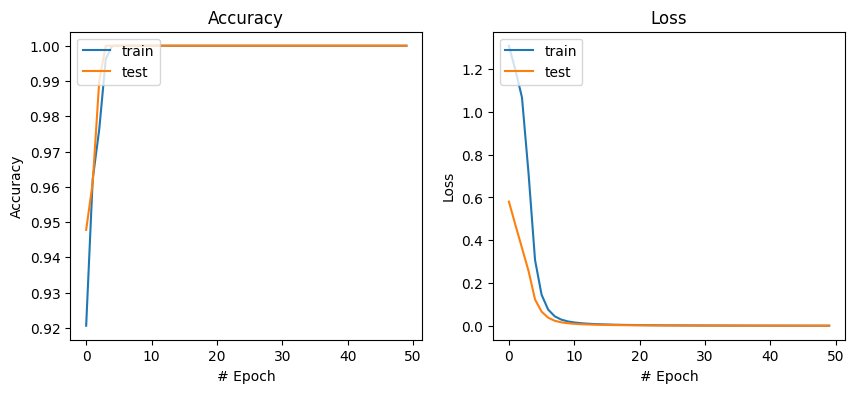

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].set_title('Loss')

In [31]:
probabilities = classifier.predict(X_test_sc) #classifier.predict(X_test_sc)

63/63 [==============================] - 0s 737us/step


In [32]:
probabilities

array([[1.3479636e-04],
       [3.8702926e-04],
       [1.5027309e-04],
       ...,
       [3.6719957e-04],
       [6.7036814e-04],
       [9.9999267e-01]], dtype=float32)

In [33]:
predictions = (probabilities > 0.5).astype('int32')


 Classification report : 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1790
         1.0       1.00      1.00      1.00       210

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy   Score :  1.0
F1 Score:  1.0
Area under curve :  1.0 



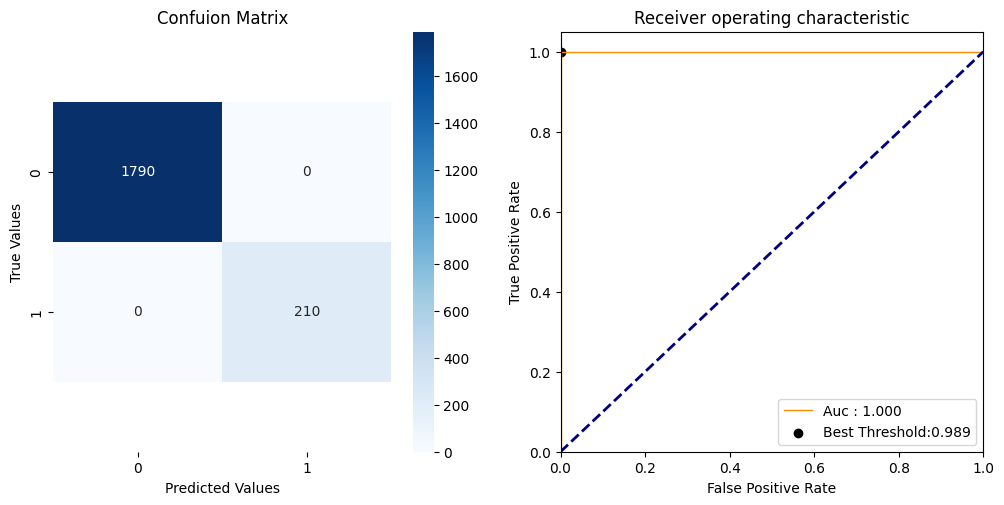

In [34]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probabilities) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()